__File: operator_evolution_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jan 07, 2020__

This notebook creates figures for _Operator evolution from the similarity renormalization group and the Magnus expansion_. Each function creates and saves a figure to the __Figures/Operator_evolution__ folder or returns values for a calculation. Below is a brief description of each function:
* phase_shifts - Plots NN phase shifts from several potentials.
* deuteron_momentum_distribution - Plots deuteron momentum distributions comparing initial and SRG-evolved $\psi^2$. Note this depicts $\psi(s)^2$ not $|\psi(s)|^2 = \psi^{\dagger}(0) U^{\dagger}(s) U(s) \psi(0) = |\psi(0)|^2$.
* continuum_state_distribution - Analog of the deuteron_momentum_distribution function but for some state $\epsilon_k$ > 0 MeV.
* potential_contours - Plots contours of SRG-evolving potentials.
* potential_contours - Analog of potential_contours but varies the SRG generator and fixes the potential.
* potential_slices - Plots the diagonal and far off-diagonal matrix elements of SRG-evolving potentials.
* potential_slices_high_cutoffs - Same as potential_slices but specific to high cutoff non-local LO potentials from Wendt 2011 (kvnn = 900-902).
* potential_slices_magnus - Analog of potential_slices functions but for comparing Magnus and SRG-evolution of high cutoff potentials from Wendt 2011.
* universality_test_with_norm - Uses the matrix norm of potentials to analyze universality in different SRG-evolved interactions.
* universality_test_with_sdt_coeff - Uses the correlation coefficient and angle from SDT to measure how similar two potentials are.
* energies_from_truncated_hamiltonian - Compares the energies of an initial Hamiltonian and an evolved Hamiltonian truncated up to some value in momentum.
* bound_states_error - Calculates the bound state energies and relative error between an initial and evolved Hamiltonian.
* eigenvalues_rms_error - Calculates the RMS error of all the energies between an initial and evolved Hamiltonian.
* momentum_projection_contours - Plots contours of SRG-evolving momentum projection operators.
* momentum_projection_integrand_contours - Plots SRG-evolved matrix elements of the momentum projection operator with the deuteron wave function.
* momentum_projection_slices - Plots the diagonal and far off-diagonal matrix elements of SRG-evolving momentum projection operators.
* unitary_transformation_contours - Plots contours of SRG unitary transformations.

__Revision history:<br/>__
* Jan 07, 2020 - Created by combining several Jupyter notebooks: srg_potentials_fig.ipynb, srg_observables_fig.ipynb, srg_operators_fig.ipynb, and magnus_fig.ipynb. Note, some of these notebooks could be in Old_codes.
* Jan 22, 2020 - Added universality_test function.
* Feb 05, 2020 - Added functions that look at the SRG unitary transformations directly.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline
from numpy import linalg as la
import numpy as np
from scipy.linalg import expm
# Scripts made by A.T.
from Figures import figures_functions as ff
from Figures import register_colormap
import observables as ob
import operators as op
from Potentials.vsrg_macos import load_save_potentials as lp
from Potentials.vsrg_macos import sdt_funcs as sdt
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Variables and constants__

In [2]:
# Number of points in momentum-mesh
ntot = 120

# NN potentials for phase shift plots and NN potential contours - (kvnn, kmax, kmid, ntot)
em_n3lo = (10, 30.0, 4.0, ntot) # EM N3LO (500 MeV) potential
emn_n4lo = (79, 10.0, 2.0, ntot) # EMN N4LO (500 MeV) potential
#rke_n4lo = (111, 8.0, 2.0, ntot) # RKE N4LO (450 MeV) potential
rke_n4lo = (111, 10.0, 2.0, ntot) # RKE N4LO (450 MeV) potential (use the kmax = 10 fm^-1 one instead)
gez_n2lo = (222, 10.0, 2.0, ntot) # Gezerlis et al. N2LO (1 fm) potential
wendt_4 = (900, 30.0, 4.0, ntot) # Wendt LO (4 fm^-1) potential
wendt_9 = (901, 30.0, 4.0, ntot) # Wendt LO (9 fm^-1) potential
wendt_20 = (902, 30.0, 4.0, ntot) # Wendt LO (20 fm^-1) potential

# SRG generators and lambda values for momentum distribution plots - (generator, lambda, lambda_bd)
wegner_1_5 = ('Wegner', 1.5)
block_diag_2 = ('Block-diag', 1.5, 2.00)
block_diag_3 = ('Block-diag', 1.5, 3.00)

# Continuum state energy for momentum distribution plots
eps = 200.0

# lambda values for potential contours
lambda_array_contours = np.array([np.inf, 3.0, 2.0, 1.5])
# lambda values for potential slices
lambda_array_slices = np.array([np.inf, 3.0, 1.5, 1.0])
# lambda values for high cutoff potentials
lambda_array_high_cutoffs = np.array([10.0, 2.8, 2.0, 1.2])
# lambda values for universality test
lambda_array_univ = np.array([6.0, 3.0, 2.0, 1.5, 1.0])
# lambda values for momentum projection operators
lambda_array_mpo = np.array([6.0, 3.0, 2.0, 1.5])
# lambda values for unitary transformations
lambda_array_unit = np.array([3.0, 1.5, 1.0])

# Used for universality test
channels = ('1S0', '3S1', '1P1', '1F3', '1G4')

# k values for Magnus truncation
k_magnus_array = np.array([2, 6, 10])

__Plotting functions__

In [3]:
def phase_shifts(channel, *potentials):
    """
    Plots phase shifts [deg] of NN potentials with respect to relative momentum [fm^-1]. This is a 1 x 1 plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    *potentials : tuple
        Specifications for phase shifts of an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) 
        is the number specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid
        (float) is the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For 
        example, (10, 30.0, 4.0, 120) corresponds to the Entem-Machleidt N3LO potential.

    Saves
    -----
    file_name : phase_shifts_ with an extension based off the given arguments. For example,
                phase_shifts_3S1_kvnns_10_106_222.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one potential must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # h-bar^2 / M [MeV fm^2]
    hbar_sq_over_M = 41.47 

    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # Relative momentum in fm^-1
    k_max = 4.0
    M = 200 # Number of points in array
    k_points = np.linspace(0.01, k_max, M)
    # We could also plot phase shifts with respect to E_lab but we choose k for comparison to potential matrix 
    # elements in momentum space
    # Conversion to E_lab
    e_array = 2.0 * hbar_sq_over_M * k_points**2
    
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # x-axis limits
    xlim = [0.0, k_max]
     
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\delta$' + ' [deg]'
    y_label_size = 20
    legend_label_size = 14
    channel_label = ff.channel_label_conversion(channel)
    channel_label_size = 22
    axes_tick_size = 14
    
    # Things which depend on the channel: y-axis limits and some label locations
    if channel == '1S0':
        ylim = [-80.0, 70.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper right'
    elif channel == '3S1':
        ylim = [-40.0, 180.0]
        legend_label_location = 'upper right'
        channel_label_location = 'lower left'
    elif channel == '1P1':
        ylim = [-60.0, 10.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper center'
    elif channel == '1F3':
        ylim = [-15.0, 10.0]
        legend_label_location = 'upper left'
        channel_label_location = 'lower left'
    else:
        ylim = [-5.0, 10.0]
        legend_label_location = 'upper left'
        channel_label_location = 'lower right'
    
    # File name of figure
    file_name = 'phase_shifts_%s_' % channel + 'kvnns'
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over specifications keeping track of the curve number i
    i = 0 # Curve number
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        # Load momentum, weights, and potential
        k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
    
        # Calculate phase shifts
        # If coupled-channel, use the Stapp convention
        if coupled_channel:
            phase_shifts_array = ob.coupled_channel_phase_shifts(e_array, V_matrix, k_array, k_weights,
                                                                 convention='Stapp')
            # Plot only delta_a_array (excludes delta_b and epsilon)
            delta_array = phase_shifts_array[:, 0]
        else:
            delta_array = ob.phase_shifts(e_array, V_matrix, k_array, k_weights)
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i) # Color
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.kvnn_label_conversion(kvnn) # Legend label
        
        # Add to figure
        ax.plot(k_points, delta_array, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
        
    # --- Set figure specifications and save --- #

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add channel as anchored text
    anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size), loc=channel_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [4]:
def deuteron_momentum_distribution(kvnn, kmax, kmid, ntot, *generators):
    """
    Plots the deuteron momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial distribution
    and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, opt) is the 
        block-diagonal cutoff [fm^-1].

    Saves
    -----
    file_name : deuteron_momentum_distribution_ with an extension based off the given arguments. For example,
                deuteron_momentum_distribution_kvnn10_Wegner_1,5_Block-diag_2,00_Block-diag_3,00.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
    
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # Limits of x and y axes
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
    
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\phi_d^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    legend_label_size = 14
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_bd_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    #lambda_label_size = 14
    axes_tick_size = 14

    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'lower left'
    
    # File name of figure
    file_name = 'deuteron_momentum_distribution_kvnn%d_' % kvnn 
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0 # Curve number
    for g in generators:
        
        generator = g[0] # SRG generator
        lamb = g[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = g[2] # Lambda_BD for block-diagonal evolution
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.2f' % lambda_bd
        else:
            # Wegner evolution - set lambda_bd to 0
            lambda_bd = 0.0
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.1f' % lamb
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        u_evolved = psi_evolved[:ntot] # 3S1 component
        w_evolved = psi_evolved[ntot:] # 3D1 component
        
        # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
        if generator == 'Block-diag': # Legend label
            curve_label = lambda_bd_label % lambda_bd 
        else:
            curve_label = lambda_label % lamb
        
        # Add to figure
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
    curve_label = lambda_inf_label # Legend label
    
    # Add to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
#     anchored_text = AnchoredText(lambda_label % lamb, prop=dict(size=lambda_label_size), loc=lambda_label_location,
#                                  frameon=False)
#     ax.add_artist(anchored_text)
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    # Show plot in notebook
    plt.show()

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [5]:
def continuum_state_momentum_distribution(eps, kvnn, channel, kmax, kmid, ntot, *generators):
    """
    Plots a continuum state momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial 
    distribution and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    eps : float
        Eigen-energy of the continuum state [MeV].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, opt) is the 
        block-diagonal cutoff [fm^-1].

    Saves
    -----
    file_name : continuum_state_momentum_distribution_ with an extension based off the given arguments. For example,
                continuum_state_momentum_distribution_kvnn10_Wegner_1,5_Block-diag_2,00_Block-diag_3,00.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    
    # Coupled-channel
    if coupled_channel:
        
        u_initial = psi_initial[:ntot] # 3S1 component
        w_initial = psi_initial[ntot:] # 3D1 component
        
        # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
        
    else:
        
        phi_squared_initial = psi_initial**2 / ( k_array**2 * k_weights )
        
    # Figure size for 1 x 1 figure
    width = 4
    height = 4
    figure_size = (width, height) # This gives a square figure
    
    # Limits of x and y axes
    xlim = [0.0, 5.0]
    ylim = [1e-6, 1e2]
    
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\phi_{\epsilon}^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
#     legend_label_size = 12
#     lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
#     lambda_bd_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
#     lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    #lambda_label_size = 14
    axes_tick_size = 14
    
    # Location of labels
    lambda_label_location = 'upper left'
    
    # Things which depend on value of epsilon: location of labels
    if eps > 200:
        legend_label_location = 'center left'
    else:
        legend_label_location = 'upper right'
    
    # File name of figure
    file_name = 'continuum_state_momentum_distribution_eps%.1f_kvnn%d_%s' % (eps, kvnn, channel)
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0 # Curve number
    for g in generators:
        
        generator = g[0] # SRG generator
        lamb = g[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = g[2] # Lambda_BD for block-diagonal evolution
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.2f' % lambda_bd
        else:
            # Wegner evolution - set lambda_bd to 0
            lambda_bd = 0.0
            # Update name of the file (based off generator)
            file_name += '_' + generator + '_%.1f' % lamb
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        
        # Coupled-channel
        if coupled_channel:
        
            u_evolved = psi_evolved[:ntot] # 3S1 component
            w_evolved = psi_evolved[ntot:] # 3D1 component
            
            # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
            phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
            
        else:
            
            phi_squared_evolved = psi_evolved**2 / ( k_array**2 * k_weights )
            
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
#         if generator == 'Block-diag': # Legend label
#             curve_label = lambda_bd_label % lambda_bd 
#         else:
#             curve_label = lambda_label % lamb
        
#         # Add to figure
#         ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
#     curve_label = lambda_inf_label # Legend label
    
#     # Add to figure
#     ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
#     ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
#     anchored_text = AnchoredText(lambda_label % lamb, prop=dict(size=lambda_label_size), loc=lambda_label_location,
#                                  frameon=False)
#     ax.add_artist(anchored_text)
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    # Show plot in notebook
    plt.show()

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [6]:
def potential_contours(channel, generator, lambda_array, *potentials):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1]. This is an 3 x 4 contour plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *potentials : tuple
        Specifications for an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number 
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example, 
        (111, 8.0, 2.0, 120) corresponds to the RKE N4LO (450 MeV) potential.

    Saves
    -----
    file_name : potential_contours_channel_kvnns_ with an extension based off the given arguments. For example,
                potential_contours_3S1_kvnns_10_111_222_Wegner.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one potential must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Size of figure
    row_number = 3
    col_number = 4
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # Limits of x and y axes
    axes_max = 4.0
    #axes_max = 10.0
    
    # Specifications of axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    #axes_stepsize = 2.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    # Labels and fontsize
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    potential_label_size = 17
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
        lambda_inf_label = r'$\Lambda_{BD}=\infty$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
        lambda_inf_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    colorbar_label = '[fm]'
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Location of labels
    lambda_label_location = 'lower left'
    potential_label_location = 'upper right'
    
    # Color scheme for contour plots
#     color_style = 'jet'
    color_style = 'turbo'
    
    # Things which depend on the channel: limits of colorbar
    if channel in ['1S0', '3S1']:
        mx = 1.0
        #mx = 0.5
        mn = -1.0
        #mn = -0.5
    elif channel == '1P1':
        mx = 0.4
        mn = -0.4
    elif channel == '1F3':
        mx = 0.04
        mn = -0.04
    else:
        mx = 0.03
        mn = -0.03
#     colorbar_norm = colors.Normalize(vmin=mn, vmax=mx)
    #levels_number = 41
    levels_number = 61
    #levels_number = 101
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 11)
    levels_ticks_strings = ['%.1f' % tick for tick in levels_ticks]
    
    # File name of figure
    file_name = 'potential_contours_%s_kvnns' % channel

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over specifications
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        d[kvnn] = {} # Store momentum and potential in here
        
        # Load momentum
        k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
            # Load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0,
                                                 lambda_bd=lamb)
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max)
            
            # Save to dictionary
            d[kvnn]['k_array'] = k_array_int
            d[kvnn][lamb] = V_matrix_int
            
            
    # --- Plot contours --- #
    
    # Initialize figure
    plt.close('all')
#     f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size, 
#                           constrained_layout=True)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    #grid = AxesGrid(f, )
    
    # Row 1 #
    kvnn_1 = potentials[0][0]
    potential_label_1 = ff.kvnn_label_conversion(kvnn_1, full_label=False)
    
    # Sub-plot 1
#     axs[0, 0].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[0]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[0, 0].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[0]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[0, 0].set_xlim( (0, axes_max) )
    axs[0, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 0].xaxis.set_ticks(axes_ticks)
    axs[0, 0].xaxis.set_ticklabels(axes_ticks)
    axs[0, 0].yaxis.set_ticks(axes_ticks)
    axs[0, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 0].xaxis.set_label_position('top')
    axs[0, 0].xaxis.tick_top()
    axs[0, 0].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = axs[0, 0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[-1].set_visible(False)
    # Set axes labels
    axs[0, 0].set_xlabel(x_label, fontsize=axes_label_size)
    axs[0, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
#     axs[0, 1].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[1]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[0, 1].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[1]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[0, 1].set_xlim( (0, axes_max) )
    axs[0, 1].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 1].xaxis.set_ticks(axes_ticks)
    axs[0, 1].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 1].xaxis.set_label_position('top')
    axs[0, 1].xaxis.tick_top()
    axs[0, 1].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = axs[0, 1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Set axes labels
    axs[0, 1].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
#     axs[0, 2].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[2]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[0, 2].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[2]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[0, 2].set_xlim( (0, axes_max) )
    axs[0, 2].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 2].xaxis.set_ticks(axes_ticks)
    axs[0, 2].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 2].xaxis.set_label_position('top')
    axs[0, 2].xaxis.tick_top()
    axs[0, 2].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = axs[0, 2].xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Set axes labels
    axs[0, 2].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
#     axs[0, 3].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[3]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[0, 3].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[3]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[0, 3].set_xlim( (0, axes_max) )
    axs[0, 3].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 3].xaxis.set_ticks(axes_ticks)
    axs[0, 3].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 3].xaxis.set_label_position('top')
    axs[0, 3].xaxis.tick_top()
    axs[0, 3].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Set axes labels
    axs[0, 3].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    # Add potential label as anchored text
    potential_anchored_text_1 = AnchoredText(potential_label_1, prop=dict(size=potential_label_size),
                                             loc=potential_label_location)
    axs[0, 3].add_artist(potential_anchored_text_1)
    
    
    # Row 2 #
    kvnn_2 = potentials[1][0]
    potential_label_2 = ff.kvnn_label_conversion(kvnn_2, full_label=False)
    
    # Sub-plot 5
#     axs[1, 0].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[0]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[1, 0].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[0]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[1, 0].set_xlim( (0, axes_max) )
    axs[1, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[1, 0].yaxis.set_ticks(axes_ticks)
    axs[1, 0].yaxis.set_ticklabels(axes_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_2 = axs[1, 0].yaxis.get_major_ticks()
    yticks_2[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 0].add_artist(lambda_anchored_text_5)
        
    # Sub-plot 6
#     axs[1, 1].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[1]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[1, 1].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[1]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[1, 1].set_xlim( (0, axes_max) )
    axs[1, 1].set_ylim( (0, axes_max) )
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
#     axs[1, 2].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[2]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[1, 2].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[2]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[1, 2].set_xlim( (0, axes_max) )
    axs[1, 2].set_ylim( (0, axes_max) )
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 2].add_artist(lambda_anchored_text_7)
    
    # Sub-plot 8
#     axs[1, 3].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[3]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[1, 3].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[3]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[1, 3].set_xlim( (0, axes_max) )
    axs[1, 3].set_ylim( (0, axes_max) )
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    # Add potential label as anchored text
    potential_anchored_text_2 = AnchoredText(potential_label_2, prop=dict(size=potential_label_size),
                                             loc=potential_label_location)
    axs[1, 3].add_artist(potential_anchored_text_2)
    
    
    # Row 3 #
    kvnn_3 = potentials[2][0]
    potential_label_3 = ff.kvnn_label_conversion(kvnn_3, full_label=False)
    
    # Sub-plot 9
#     axs[2, 0].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[0]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[2, 0].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[0]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[2, 0].set_xlim( (0, axes_max) )
    axs[2, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[2, 0].yaxis.set_ticks(axes_ticks)
    axs[2, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[2, 0].xaxis.tick_top()
    axs[2, 0].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Set axes labels
    axs[2, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_9 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[2, 0].add_artist(lambda_anchored_text_9)
    
    # Sub-plot 10
#     axs[2, 1].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[1]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[2, 1].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[1]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[2, 1].set_xlim( (0, axes_max) )
    axs[2, 1].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[2, 1].xaxis.tick_top()
    axs[2, 1].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_10 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                           loc=lambda_label_location)
    axs[2, 1].add_artist(lambda_anchored_text_10)
    
    # Sub-plot 11
#     axs[2, 2].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[2]], cmap=color_style, 
#                          vmin=mn, vmax=mx, rasterized=True)
    axs[2, 2].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[2]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[2, 2].set_xlim( (0, axes_max) )
    axs[2, 2].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[2, 2].xaxis.tick_top()
    axs[2, 2].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_11 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                           loc=lambda_label_location)
    axs[2, 2].add_artist(lambda_anchored_text_11)
    
    # Sub-plot 12
#     c = axs[2, 3].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[3]], 
#                              cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    c = axs[2, 3].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[3]], levels,
                       cmap=color_style, extend='both')
    # Specify axes limits
    axs[2, 3].set_xlim( (0, axes_max) )
    axs[2, 3].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[2, 3].xaxis.tick_top()
    axs[2, 3].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_12 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                           loc=lambda_label_location)
    axs[2, 3].add_artist(lambda_anchored_text_12)
    # Add potential label as anchored text
    potential_anchored_text_3 = AnchoredText(potential_label_3, prop=dict(size=potential_label_size),
                                             loc=potential_label_location)
    axs[2, 3].add_artist(potential_anchored_text_3)

    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
#     f.colorbar(c, ax=axs, pad=0.,)  # Requires constrained_layout to look nice
#     f.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
    # Show plot in notebook
    plt.show()

    # Add generator to file name
    file_name += '_%s' % generator
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
#     f.savefig(file_name+'.pdf')
    chdir(cwd)

In [7]:
def potential_contours_generators(kvnn, channel, kmax, kmid, ntot, lambda_array):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1]. This is an 2 x 4 contour plot. Analogous 
    to potential_contours function but compares SRG band- and block-diagonal decoupling fixing the NN potential.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Saves
    -----
    file_name : potential_contours_generators_channel_kvnn_ with an extension based off the given arguments. For 
                example, potential_contours_generators_3S1_kvnn_111.pdf.
    
    """
    
    
    # --- Set-up --- #
    
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # Limits of x and y axes
    axes_max = 4.0
    
    # Specifications of x and y axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    # Labels and fontsize
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    generator_label_size = 17
    # Label the block-diagonal Lambda
    Lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    Lambda_inf_label = r'$\Lambda_{BD}=\infty$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_inf_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    colorbar_label = '[fm]'
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Location of labels
    lambda_label_location = 'lower left'
    generator_label_location = 'upper right'
    
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Things which depend on the channel: limits of colorbar
    if channel in ['1S0', '3S1']:
        mx = 1.0
        mn = -1.0
    elif channel in ['1P1']:
        mx = 0.4
        mn = -0.4
    else:
        mx = 1.0
        mn = -1.0
    
    # File name of figure
    file_name = 'potential_contours_generators_%s_kvnn_%d' % (channel, kvnn)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Load momentum
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Loop over generators
    for generator in generators:
        
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
            # Load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0,
                                                 lambda_bd=lamb)
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max)
            
            # Save to dictionary
            d[generator][lamb] = V_matrix_int
            
            
    # --- Plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    
    # Row 1 #
    generator_label_1 = ff.generator_label_conversion(generators[0])
    
    # Sub-plot 1
    axs[0, 0].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[0]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 0].set_xlim( (0, axes_max) )
    axs[0, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 0].xaxis.set_ticks(axes_ticks)
    axs[0, 0].xaxis.set_ticklabels(axes_ticks)
    axs[0, 0].yaxis.set_ticks(axes_ticks)
    axs[0, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 0].xaxis.set_label_position('top')
    axs[0, 0].xaxis.tick_top()
    axs[0, 0].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axistick marks
    xticks_1 = axs[0, 0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[-1].set_visible(False)
    # Set axes labels
    axs[0, 0].set_xlabel(x_label, fontsize=axes_label_size)
    axs[0, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[1]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 1].set_xlim( (0, axes_max) )
    axs[0, 1].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 1].xaxis.set_ticks(axes_ticks)
    axs[0, 1].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 1].xaxis.set_label_position('top')
    axs[0, 1].xaxis.tick_top()
    axs[0, 1].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = axs[0, 1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Set axes labels
    axs[0, 1].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[2]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 2].set_xlim( (0, axes_max) )
    axs[0, 2].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 2].xaxis.set_ticks(axes_ticks)
    axs[0, 2].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 2].xaxis.set_label_position('top')
    axs[0, 2].xaxis.tick_top()
    axs[0, 2].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = axs[0, 2].xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Set axes labels
    axs[0, 2].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[3]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 3].set_xlim( (0, axes_max) )
    axs[0, 3].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 3].xaxis.set_ticks(axes_ticks)
    axs[0, 3].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 3].xaxis.set_label_position('top')
    axs[0, 3].xaxis.tick_top()
    axs[0, 3].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Set axes labels
    axs[0, 3].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    # Add potential label as anchored text
    generator_anchored_text_1 = AnchoredText(generator_label_1, prop=dict(size=generator_label_size),
                                             loc=generator_label_location)
    axs[0, 3].add_artist(generator_anchored_text_1)
    
    
    # Row 2 #
    generator_label_2 = ff.generator_label_conversion(generators[1])
    
    # Sub-plot 5
    axs[1, 0].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[0]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 0].set_xlim( (0, axes_max) )
    axs[1, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[1, 0].yaxis.set_ticks(axes_ticks)
    axs[1, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[1, 0].xaxis.tick_top()
    axs[1, 0].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(Lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[1]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 1].set_xlim( (0, axes_max) )
    axs[1, 1].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 1].xaxis.tick_top()
    axs[1, 1].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(Lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[2]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 2].set_xlim( (0, axes_max) )
    axs[1, 2].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 2].xaxis.tick_top()
    axs[1, 2].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(Lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 2].add_artist(lambda_anchored_text_7)
    
    # Sub-plot 8
    c = axs[1, 3].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[3]], cmap=color_style, vmin=mn, 
                             vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 3].set_xlim( (0, axes_max) )
    axs[1, 3].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 3].xaxis.tick_top()
    axs[1, 3].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(Lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    # Add potential label as anchored text
    generator_anchored_text_2 = AnchoredText(generator_label_2, prop=dict(size=generator_label_size),
                                             loc=generator_label_location)
    axs[1, 3].add_artist(generator_anchored_text_2)

    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [8]:
def potential_slices(channel, lambda_array, *potentials):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far 
    off-diagonal matrix elements. This is an 2 x 4 plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *potentials : tuple
        Specifications for an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number 
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example, 
        (111, 8.0, 2.0, 120) corresponds to the RKE N4LO (450 MeV) potential.

    Saves
    -----
    file_name : potential_slices_channel_kvnns_ with an extension based off the given arguments. For example,
                potential_slices_3S1_kvnns_10_111_222.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one SRG-evolved potential must be specified.')
        return None

    
    # --- Set-up --- #
    
    # Store kvnn values in this list
    kvnns = []
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x axis
    xlim = [0.0, 3.0]
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = 'V(k,k) [fm]'
    y_label_size = 20
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    legend_label_size = 16
    # Add channel label for diagonal element plot only
    channel_label = ff.channel_label_conversion(channel)
    channel_label_size = 22
    lambda_inf_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=\infty$' + ' fm' + r'$^{-1}$'
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    axes_tick_size = 16
    
    # Location of labels
    channel_label_location = 'lower right'
    lambda_label_location = 'upper left'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
    
    # Things which depend on the channel: limits and stepsize of y-axis, y-axis label, location of legend label
    if channel == '1S0':
        ylim = [-3.5, 2.0]
        y_stepsize = 1
        formatter = tkr.FormatStrFormatter('%.1f')
        # Set off-diagonal k = 0 fm^-1 for other channels
        y_label_off_diag = 'V(k,0) [fm]'
        legend_label_location = 'lower right'
    elif channel == '3S1':
        ylim = [-4.5, 2.0]
        y_stepsize = 1
        formatter = tkr.FormatStrFormatter('%.1f')
        # Set off-diagonal k = 0 fm^-1 for other channels
        y_label_off_diag = 'V(k,0) [fm]'
        legend_label_location = 'lower right'
    elif channel == '1P1':
        ylim = [-0.5, 0.8]
        y_stepsize = 0.25
        formatter = tkr.FormatStrFormatter('%.2f')
        # Set off-diagonal k = 0.5 fm^-1 for 1P1 channel
        y_label_off_diag = 'V(k,0.5) [fm]'
        legend_label_location = 'lower right'
    elif channel == '1F3':
        ylim = [-0.03, 0.06]
        y_stepsize = 0.015
        formatter = tkr.FormatStrFormatter('%.2f')
        y_label_off_diag = 'V(k,1) [fm]'
        legend_label_location = 'lower right'
    else:
        ylim = [-0.04, 0.02]
        y_stepsize = 0.01
        formatter = tkr.FormatStrFormatter('%.2f')
        y_label_off_diag = 'V(k,2) [fm]'
        legend_label_location = 'lower left'
        
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
    y_tick_labels = ['%.2f' % iy for iy in y_ticks]

    # File name of figure
    file_name = 'potential_slices_%s_kvnns' % channel # This reads 'potential_slices_channel_kvnns'

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over specifications
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Append to kvnn list
        kvnns.append(kvnn)
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        d[kvnn] = {} # Store momentum and potential in here
        
        # Load momentum
        k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        d[kvnn]['k_array'] = k_array
        
        # Loop over SRG generators
        for generator in generators:
            
            d[kvnn][generator] = {}
            
            # Loop over lambda values
            for lamb in lambda_array:
            
                d[kvnn][generator][lamb] = {} # Split into cases on diagonals and far off-diagonals
            
                # Load initial potential if lambda = infinity
                if lamb == np.inf:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
                # Load evolved potential
                else:
                    if generator == 'Block-diag':
                        # For block-diagonal, set lambda = 1 fm^-1
                        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0, 
                                                     lambda_bd=lamb)
                            
                    else:
                        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
                # Save to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( V_matrix )[:ntot]
                if channel == '1P1': # For 1P1 channel, select a slice where k does not equal zero
                    k = 0.5
                    k_index = op.find_q_index(k, k_array) # k_array[k_index] ~ 0.5 fm^-1 (closest value to 0.5)
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                elif channel == '1F3':
                    k = 1.0
                    k_index = op.find_q_index(k, k_array) 
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                elif channel == '1G4':
                    k = 2.0
                    k_index = op.find_q_index(k, k_array) 
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                else:
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Labels for potentials
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    axs[0, 0].yaxis.set_major_formatter(formatter)
    axs[0, 0].yaxis.set_ticks(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Set legend label
    axs[0, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    axs[0, 0].yaxis.set_major_formatter(formatter)
    axs[1, 0].yaxis.set_ticks(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    # Set legend label
    axs[1, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_inf_label, prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 2].add_artist(lambda_anchored_text_7)
                   
    # Sub-plot 8
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    # Add channel label as anchored text
    channel_anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size),
                                         loc=channel_label_location, frameon=False)
    axs[1, 3].add_artist(channel_anchored_text)
    

    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [9]:
def potential_slices_high_cutoffs(lambda_array):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far 
    off-diagonal matrix elements. This is an 2 x 4 plot. This function is analogous to potential_slices but specific
    to high cutoff potentials in the 3S1 channel.
    
    Parameters
    ----------
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Saves
    -----
    file_name : potential_slices_high_cutoffs_kvnns_ with an extension based off the given arguments. For 
                example, potential_slices_high_cutoffs_kvnns_900_901_902.pdf.
    
    """

    
    # --- Set-up --- #
    
    # Specifications of high cutoff potentials
    kvnns = [900, 901, 902]
    channel = '3S1' # Partial wave channel
    kmax = 30.0 # Max momentum value in mesh
    kmid = 4.0 # Mid-point in mesh
    ntot = 120 # Number of points in mesh
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x and y axes
    xlim = [0.0, 3.0]
    ylim = [-4.0, 4.5]
    
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    y_stepsize = 1
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = 'V(k,k) [fm]'
    y_label_off_diag = 'V(k,0) [fm]'
    y_label_size = 20
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    legend_label_size = 17
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    axes_tick_size = 16
    
    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'upper left'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
        
    # File name of figure
    file_name = 'potential_slices_high_cutoffs_kvnns_%s_%s_%s' % (kvnns[0], kvnns[1], kvnns[2])

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over specifications
    for kvnn in kvnns:
        
        d[kvnn] = {} # Store momentum and potential in here

        # Load momentum
        k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        d[kvnn]['k_array'] = k_array
        
        # Loop over SRG generators
        for generator in generators:
            
            d[kvnn][generator] = {}
            
            # Loop over lambda values
            for lamb in lambda_array:
            
                d[kvnn][generator][lamb] = {} # Split into cases on diagonals and far off-diagonals
            
                # Load evolved potential
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda to lowest value
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator,
                                                 lambda_array[-1], lambda_bd=lamb)
                            
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
                # Save to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( V_matrix )[:ntot]
                d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    axs[0, 0].yaxis.set_ticks(y_ticks)
    axs[0, 0].yaxis.set_ticklabels(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    axs[1, 0].yaxis.set_ticks(y_ticks)
    axs[1, 0].yaxis.set_ticklabels(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    
    # Sub-plot 6
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    
    # Sub-plot 7
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Set legend label
    axs[1, 2].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)

                   
    # Sub-plot 8
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Set legend label
    axs[1, 3].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    

    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [10]:
def potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_array):
    """
    Plots SRG- and Magnus-evolved NN non-local LO potentials [fm] with respect to momentum [fm^-1] isolating the 
    diagonal and far off-diagonal matrix elements. This is an 2 x 4 plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    k_magnus_array : 1-D ndarray
        Array of k_magnus values which are the number of terms to include in Magnus sum (that is,
        dOmega / ds ~ \sum_0^k_magnus). Make sure these values are positive integers.
        
    Saves
    -----
    file_name : potential_slices_magnus_kvnn_ with an extension based off the given arguments. For example,
                potential_slices_magnus_kvnn_901_Wegner.pdf.
    
    """

    
    # --- Set-up --- #
    
    # Specifications for non-local LO potential
    channel = '3S1'
    kmax = 30.0
    kmid = 4.0
    ntot = 120
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x and y axes
    xlim = [0.0, 3.0]
    ylim = [-4.0, 2.5]
    
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    y_stepsize = 1
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = 'V(k,k) [fm]'
    y_label_off_diag = 'V(k,0) [fm]'
    y_label_size = 20
    legend_label = r'$k_{\rm max}$' + '=%d'
    legend_label_size = 17
    potential_label = ff.kvnn_label_conversion(kvnn)
    potential_label_size = 20
    generator_label = ff.generator_label_conversion(generator)
    generator_label_size = 20
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 17
    axes_tick_size = 16
    
    # Location of labels
    legend_label_location = 'upper left'
    potential_label_location = 'center left'
    generator_label_location = 'lower right'
    lambda_label_location = 'upper left'
    
    # Line colors and styles
    srg_color = 'xkcd:black'
    k_magnus_1_color = 'xkcd:blue'
    k_magnus_2_color = 'xkcd:red'
    k_magnus_3_color = 'xkcd:green'
    srg_style = 'dotted'
    k_magnus_1_style = 'solid'
    k_magnus_2_style = 'dashdot'
    k_magnus_3_style = 'dashed'
    
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 0.5
    y_stepsize = 1
        
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
    
    # File name of figure
    file_name = 'potential_slices_magnus_kvnn_%d_%s' % (kvnn, generator)

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Load momentum
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Loop over lambda values
    for lamb in lambda_array:
        
        d[lamb] = {}
        d[lamb]['SRG'] = {}
            
        # Load SRG-evolved potential here    
        if generator == 'Block-diag':
            # For block-diagonal, set lambda to lowest value
            V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lambda_array[-1], 
                                         lambda_bd=lamb)
        else:
            V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
        # Save to dictionary
        d[lamb]['SRG']['diag'] = np.diag( V_matrix )[:ntot]
        d[lamb]['SRG']['off-diag'] = V_matrix[:ntot, 0]
        
        # Set ds = 10^-6 if lambda = 10 fm^-1
        if lamb == 10.0:
            ds = 1e-6
        else:
            ds = 1e-5
        
        # Loop over k_magnus values
        for k_magnus in k_magnus_array:
            
            d[lamb][k_magnus] = {}
            
            # Load SRG-evolved potential here    
            if generator == 'Block-diag':
                # For block-diagonal, set lambda = 1 fm^-1
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'magnus', generator, lambda_array[-1], 
                                             lamb, k_magnus, ds)
            else:
                V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'magnus', generator, lamb, 
                                             k_magnus=k_magnus, ds=ds)
                
            # Save to dictionary
            d[lamb][k_magnus]['diag'] = np.diag( V_matrix )[:ntot]
            d[lamb][k_magnus]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(k_array, d[lambda_array[0]]['SRG']['diag'], color=srg_color, linestyle=srg_style)
    axs[0, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[0]]['diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[0, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[1]]['diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[0, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[2]]['diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    axs[0, 0].yaxis.set_ticks(y_ticks)
    axs[0, 0].yaxis.set_ticklabels(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    # Add potential label as anchored text
    potential_anchored_text = AnchoredText(potential_label, prop=dict(size=potential_label_size),
                                           loc=potential_label_location, frameon=False)
    axs[0, 0].add_artist(potential_anchored_text)
    
    # Sub-plot 2
    axs[0, 1].plot(k_array, d[lambda_array[1]]['SRG']['diag'], color=srg_color, linestyle=srg_style)
    axs[0, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[0]]['diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[0, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[1]]['diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[0, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[2]]['diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(k_array, d[lambda_array[2]]['SRG']['diag'], color=srg_color, linestyle=srg_style)
    axs[0, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[0]]['diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[0, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[1]]['diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[0, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[2]]['diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(k_array, d[lambda_array[3]]['SRG']['diag'], color=srg_color, linestyle=srg_style)
    axs[0, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[0]]['diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[0, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[1]]['diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[0, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[2]]['diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(k_array, d[lambda_array[0]]['SRG']['off-diag'], color=srg_color, linestyle=srg_style, 
                   label='SRG')
    axs[1, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[0]]['off-diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style, label=legend_label % k_magnus_array[0])
    axs[1, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[1]]['off-diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style, label=legend_label % k_magnus_array[1])
    axs[1, 0].plot(k_array, d[lambda_array[0]][k_magnus_array[2]]['off-diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style, label=legend_label % k_magnus_array[2])
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    axs[1, 0].yaxis.set_ticks(y_ticks)
    axs[1, 0].yaxis.set_ticklabels(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    # Set legend label
    axs[1, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    
    # Sub-plot 6
    axs[1, 1].plot(k_array, d[lambda_array[1]]['SRG']['off-diag'], color=srg_color, linestyle=srg_style)
    axs[1, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[0]]['off-diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[1, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[1]]['off-diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[1, 1].plot(k_array, d[lambda_array[1]][k_magnus_array[2]]['off-diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    
    # Sub-plot 7
    axs[1, 2].plot(k_array, d[lambda_array[2]]['SRG']['off-diag'], color=srg_color, linestyle=srg_style)
    axs[1, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[0]]['off-diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[1, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[1]]['off-diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[1, 2].plot(k_array, d[lambda_array[2]][k_magnus_array[2]]['off-diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
                   
    # Sub-plot 8
    axs[1, 3].plot(k_array, d[lambda_array[3]]['SRG']['off-diag'], color=srg_color, linestyle=srg_style)
    axs[1, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[0]]['off-diag'], color=k_magnus_1_color, 
                   linestyle=k_magnus_1_style)
    axs[1, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[1]]['off-diag'], color=k_magnus_2_color, 
                   linestyle=k_magnus_2_style)
    axs[1, 3].plot(k_array, d[lambda_array[3]][k_magnus_array[2]]['off-diag'], color=k_magnus_3_color, 
                   linestyle=k_magnus_3_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add generator label as anchored text
    generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                           loc=generator_label_location, frameon=False)
    axs[1, 3].add_artist(generator_anchored_text)
    

    # --- Set figure specifications and save --- #
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [11]:
def universality_test_with_norm(channels, generator, lambda_array, *potentials):
    """
    Plots the norm of \delta V(k, k') [fm] with respect to momentum [fm^-1] where \delta V(k, k') is the difference
    of two different SRG-evolved potentials truncated at some momentum value. This is an 1 x 3 semi-log
    plot.
    
    Parameters
    ----------
    channels : tuple
        Partial wave channels in the format (channel_1, channel_2, ...) where each channel is a string (e.g.
        ('1S0, '3S1', ...))
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *potentials : tuple
        Specifications for an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number 
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example,
        (111, 8.0, 2.0, 120) corresponds to the RKE N4LO (450 MeV) potential. Note, only input three potentials.

    Saves
    -----
    file_name : universality_test_with_norm_generator_channels_ with an extension based off the given arguments. For 
                example, universality_test_with_norm_Wegner_channels_1S0_3S1_kvnns_79_111_222.pdf.
    
    """
    

    # Check that two potentials were provided
    if len(potentials) != 3: 
        print('Three potentials must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Potential specifications
    kvnn_1 = potentials[0][0]
    kmax_1 = potentials[0][1]
    kmid_1 = potentials[0][2]
    ntot_1 = potentials[0][3]
    kvnn_2 = potentials[1][0]
    kmax_2 = potentials[1][1]
    kmid_2 = potentials[1][2]
    ntot_2 = potentials[1][3]
    kvnn_3 = potentials[2][0]
    kmax_3 = potentials[2][1]
    kmid_3 = potentials[2][2]
    ntot_3 = potentials[2][3]

    # Load momentum - technically this doesn't depend on channel
    k_array_1, _ = lp.load_momentum(kvnn_1, channels[0], kmax_1, kmid_1, ntot_1) 
    k_array_2, _ = lp.load_momentum(kvnn_2, channels[0], kmax_2, kmid_2, ntot_2)
    k_array_3, _ = lp.load_momentum(kvnn_3, channels[0], kmax_3, kmid_3, ntot_3)
    
    # Size of figure
    row_number = 1
    col_number = 3
    figure_size = (4*col_number, 4*row_number)
    
    # y-axis limits
    ylim = [5e-4, 2e0]
    
    # Specifications of x-axis
    # Step-size in labeling tick marks
    x_stepsize = 1.0
    # x-axis ticks
    x_ticks = np.arange(0.0, lambda_array[0] + x_stepsize, x_stepsize)
    formatter = tkr.FormatStrFormatter('%.1f')

    # Labels and fontsize
    if generator == 'Block-diag':
        x_label = r'$\Lambda_{BD}$' + ' [fm' + r'$^{-1}$' + ']'
    else:
        x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = '||' + r'$\Delta$' + "V(k,k')|| [fm" + r'$^{-1}$' + ']'
    y_label_size = 20
    legend_label_size = 15
    generator_label = ff.generator_label_conversion(generator)
    generator_label_size = 20
    potentials_label = '%s\n%s'
    potentials_label_size = 16
    kvnn_1_label = ff.kvnn_label_conversion(kvnn_1)
    kvnn_2_label = ff.kvnn_label_conversion(kvnn_2)
    kvnn_3_label = ff.kvnn_label_conversion(kvnn_3)
    axes_tick_size = 14
    
    # Location of labels
    legend_label_location = 'upper left'
    generator_label_location = 'lower left'
    potentials_label_location = 'lower right'
    
    # File name of figure
    file_name = 'universality_test_with_norm_%s_channels' % generator
    for channel in channels:
        file_name += '_%s' % channel
    file_name += '_kvnns_%d_%d_%d' % (kvnn_1, kvnn_2, kvnn_3)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data --- #
    
    # Initialize dictionary to store norms in array
    d = {}
    
    # Loop over channels
    for channel in channels:
        
        # We will split the dictionary into three parts for each pair of potentials: 12, 23, 31
        d[channel] = {}
    
        norms_array_12 = np.zeros(len(lambda_array))
        norms_array_23 = np.zeros(len(lambda_array))
        norms_array_31 = np.zeros(len(lambda_array))
    
        i = 0
        # Loop over lambda values
        for lamb in lambda_array:
    
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1)
                V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2)
                V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3)
            # Load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1, 'srg', generator, 1.0,
                                                   lambda_bd=lamb)
                    V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2, 'srg', generator, 1.0,
                                                   lambda_bd=lamb)
                    V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3, 'srg', generator, 1.0,
                                                   lambda_bd=lamb)
                else:
                    V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1, 'srg', generator, lamb)
                    V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2, 'srg', generator, lamb)
                    V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3, 'srg', generator, lamb)
                    
            # Select truncation value
            k_truncate = lamb
        
            # Index to truncate potential matrices
            k_truncate_index_1 = op.find_q_index(k_truncate, k_array_1)
            k_truncate_index_2 = op.find_q_index(k_truncate, k_array_2)
            k_truncate_index_3 = op.find_q_index(k_truncate, k_array_3)
                
            # Truncate matrices and momentum arrays
            V_truncated_1 = V_matrix_1[:k_truncate_index_1, :k_truncate_index_1]
            V_truncated_2 = V_matrix_2[:k_truncate_index_2, :k_truncate_index_2]
            V_truncated_3 = V_matrix_3[:k_truncate_index_3, :k_truncate_index_3]
        
            # Set overall matrix norm to divide by (should scale with truncation so we don't see decrease from 
            # solely from truncating at smaller values of k)
            overall_matrix_norm =  ( la.norm(V_truncated_1) + la.norm(V_truncated_2) + la.norm(V_truncated_3) ) / 3
                
            # Take the difference and calculate the matrix norms
            delta_V_truncated_12 = V_truncated_1 - V_truncated_2
            norms_array_12[i] = la.norm(delta_V_truncated_12) / overall_matrix_norm
            delta_V_truncated_23 = V_truncated_2 - V_truncated_3
            norms_array_23[i] = la.norm(delta_V_truncated_23) / overall_matrix_norm
            delta_V_truncated_31 = V_truncated_3 - V_truncated_1
            norms_array_31[i] = la.norm(delta_V_truncated_31) / overall_matrix_norm
            
            i += 1
            
        # Store in dictionary
        d[channel]['12'] = norms_array_12
        d[channel]['23'] = norms_array_23
        d[channel]['31'] = norms_array_31
        
            
    # --- Plot, set figure specifications, and save --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Plot looping over channels
    j = 0
    for channel in channels:
        
        curve_color = ff.xkcd_colors(j)
        axs[0].semilogy(lambda_array, d[channel]['12'], color=curve_color, linestyle='dotted', marker='o')
        axs[1].semilogy(lambda_array, d[channel]['23'], color=curve_color, linestyle='dotted', marker='o')
        axs[2].semilogy(lambda_array, d[channel]['31'], color=curve_color, linestyle='dotted', marker='o',
                        label=ff.channel_label_conversion(channel))
        j += 1
    
    # Loop over sub-plots
    for k in range(3):
        
        # Specify axes limits
        axs[k].set_ylim(ylim)
        # Set axes labels
        axs[k].set_xlabel(x_label, fontsize=x_label_size)
        # Set x-axis tick mark labels and enlarge tick marks
        axs[k].xaxis.set_major_formatter(formatter)
        axs[k].xaxis.set_ticks(x_ticks)
        axs[k].tick_params(labelsize=axes_tick_size)
        
    # Add y-axis label
    axs[0].set_ylabel(y_label, fontsize=y_label_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = axs[0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    xticks_2 = axs[1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Add generator label as anchored text
    generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size), 
                                           loc=generator_label_location, frameon=False)
    axs[0].add_artist(generator_anchored_text)
    # Add potentials label as anchored text
    potentials_anchored_text_12 = AnchoredText(potentials_label % (kvnn_1_label, kvnn_2_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[0].add_artist(potentials_anchored_text_12)
    potentials_anchored_text_23 = AnchoredText(potentials_label % (kvnn_2_label, kvnn_3_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[1].add_artist(potentials_anchored_text_23)
    potentials_anchored_text_31 = AnchoredText(potentials_label % (kvnn_3_label, kvnn_1_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[2].add_artist(potentials_anchored_text_31)
    # Add legend
    axs[2].legend(bbox_to_anchor=(1.05, 1), loc=legend_label_location, borderaxespad=0., fontsize=legend_label_size)
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)  

In [12]:
def universality_test_with_sdt_coeff(channels, generator, lambda_array, *potentials):
    """
    Plots the correlation coefficient angle from SDT between two potentials the comparing initial to SRG-evolved.
    This is a 1 x 3 plot.
    
    Parameters
    ----------
    channels : tuple
        Partial wave channels in the format (channel_1, channel_2, ...) where each channel is a string (e.g.
        ('1S0, '3S1', ...))
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *potentials : tuple
        Specifications for an NN potential in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number 
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example,
        (111, 10.0, 2.0, 120) corresponds to the RKE N4LO (450 MeV) potential. Note, only input three potentials.

    Saves
    -----
    file_name : universality_test_with_sdt_coeff_generator_channels_with an extension based off the given arguments.
                For example, universality_test_with_sdt_coeff_Wegner_channels_1S0_3S1_1P1_kvnns_79_111_222.pdf.
    
    """
    

    # Check that three potentials were provided
    if len(potentials) != 3: 
        print('Three potentials must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Initialize dictionary to store coefficients
    d = {}
    
    # Potential specifications
    kvnn_1 = potentials[0][0]
    kmax_1 = potentials[0][1]
    kmid_1 = potentials[0][2]
    ntot_1 = potentials[0][3]
    kvnn_2 = potentials[1][0]
    kmax_2 = potentials[1][1]
    kmid_2 = potentials[1][2]
    ntot_2 = potentials[1][3]
    kvnn_3 = potentials[2][0]
    kmax_3 = potentials[2][1]
    kmid_3 = potentials[2][2]
    ntot_3 = potentials[2][3]
    
    # Load momentum - technically this doesn't depend on channel
    k_array_1, _ = lp.load_momentum(kvnn_1, channels[0], kmax_1, kmid_1, ntot_1) 
    k_array_2, _ = lp.load_momentum(kvnn_2, channels[0], kmax_2, kmid_2, ntot_2)
    k_array_3, _ = lp.load_momentum(kvnn_3, channels[0], kmax_3, kmid_3, ntot_3)
    
    # Label for \lambda or \Lambda
    if generator == 'Block-diag':
        lambda_label = '\Lambda fm^-1'
    else:
        lambda_label = '\lambda fm^-1'
    
    # Size of figure
    row_number = 1
    col_number = 3
    figure_size = (4*col_number, 4*row_number)
    
    # y-axis limits
    ylim = [-5.0, 95.0]
    
    # Specifications of x-axis
    # Step-size in labeling tick marks
    x_stepsize = 1.0
    # x-axis ticks
    x_ticks = np.arange(0.0, lambda_array[0] + x_stepsize, x_stepsize)
    formatter = tkr.FormatStrFormatter('%.1f')
    
    # Labels and fontsize
    if generator == 'Block-diag':
        x_label = r'$\Lambda_{BD}$' + ' [fm' + r'$^{-1}$' + ']'
    else:
        x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\theta$' + ' [deg]'
    y_label_size = 20
    legend_label_size = 15
    generator_label = ff.generator_label_conversion(generator)
    generator_label_size = 20
    potentials_label = '%s\n%s'
    potentials_label_size = 16
    kvnn_1_label = ff.kvnn_label_conversion(kvnn_1)
    kvnn_2_label = ff.kvnn_label_conversion(kvnn_2)
    kvnn_3_label = ff.kvnn_label_conversion(kvnn_3)
    axes_tick_size = 14
    
    # Location of labels
    legend_label_location = 'upper left'
    generator_label_location = 'lower right'
    potentials_label_location = 'upper left'
    
    # File name of figure
    file_name = 'universality_test_with_sdt_coeff_%s_channels' % generator
    for channel in channels:
        file_name += '_%s' % channel
    file_name += '_kvnns_%d_%d_%d' % (kvnn_1, kvnn_2, kvnn_3)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data --- #
    
    # Initialize dictionary to store angles in array
    d = {}
    
    # Loop over channels
    for channel in channels:
        
        # We will split the dictionary into three parts for each pair of potentials: 12, 23, 31
        d[channel] = {}

        angles_array_12 = np.zeros(len(lambda_array))
        angles_array_23 = np.zeros(len(lambda_array))
        angles_array_31 = np.zeros(len(lambda_array))
    
        i = 0
        # Loop over lambda values
        for lamb in lambda_array:
        
            # For block-diagonal decoupling take \lambda=1 fm^-1 and \Lambda = lamb
            if generator == 'Block-diag':
        
                V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1, 'srg', generator, 1.0, lamb)
                V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2, 'srg', generator, 1.0, lamb)
                V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3, 'srg', generator, 1.0, lamb)
        
            else:
            
                V_matrix_1 = lp.load_potential(kvnn_1, channel, kmax_1, kmid_1, ntot_1, 'srg', generator, lamb)
                V_matrix_2 = lp.load_potential(kvnn_2, channel, kmax_2, kmid_2, ntot_2, 'srg', generator, lamb)
                V_matrix_3 = lp.load_potential(kvnn_3, channel, kmax_3, kmid_3, ntot_3, 'srg', generator, lamb)
                
            # Truncate to lamb
            k_truncate = lamb
        
            # Index to truncate potential matrices
            k_truncate_index_1 = op.find_q_index(k_truncate, k_array_1)
            k_truncate_index_2 = op.find_q_index(k_truncate, k_array_2)
            k_truncate_index_3 = op.find_q_index(k_truncate, k_array_3)
                
            # Truncate matrices and momentum arrays
            V_truncated_1 = V_matrix_1[:k_truncate_index_1, :k_truncate_index_1]
            V_truncated_2 = V_matrix_2[:k_truncate_index_2, :k_truncate_index_2]
            V_truncated_3 = V_matrix_3[:k_truncate_index_3, :k_truncate_index_3]
            
            # Calculate coefficients and angles, and store in dictionary
            #coeff_12 = sdt.correlation_coefficient(V_matrix_1, V_matrix_2)
            coeff_12 = sdt.correlation_coefficient(V_truncated_1, V_truncated_2)
            angles_array_12[i] = np.degrees( np.arccos(coeff_12) )
            #coeff_23 = sdt.correlation_coefficient(V_matrix_2, V_matrix_3)
            coeff_23 = sdt.correlation_coefficient(V_truncated_2, V_truncated_3)
            angles_array_23[i] = np.degrees( np.arccos(coeff_23) )
            #coeff_31 = sdt.correlation_coefficient(V_matrix_3, V_matrix_1)
            coeff_31 = sdt.correlation_coefficient(V_truncated_3, V_truncated_1)
            angles_array_31[i] = np.degrees( np.arccos(coeff_31) )
            #coeff = sdt.correlation_coefficient(V_truncated_1, V_truncated_2)

            i += 1
            
        # Store in dictionary
        d[channel]['12'] = angles_array_12
        d[channel]['23'] = angles_array_23
        d[channel]['31'] = angles_array_31
        

    # --- Plot, set figure specifications, and save --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Plot looping over channels
    j = 0
    for channel in channels:
        
        curve_color = ff.xkcd_colors(j)
        axs[0].plot(lambda_array, d[channel]['12'], color=curve_color, linestyle='dotted', marker='o')
        axs[1].plot(lambda_array, d[channel]['23'], color=curve_color, linestyle='dotted', marker='o')
        axs[2].plot(lambda_array, d[channel]['31'], color=curve_color, linestyle='dotted', marker='o',
                    label=ff.channel_label_conversion(channel))
        j += 1
    
    # Loop over sub-plots
    for k in range(3):
        
        # Specify axes limits
        axs[k].set_ylim(ylim)
        # Set axes labels
        axs[k].set_xlabel(x_label, fontsize=x_label_size)
        # Set x-axis tick mark labels and enlarge tick marks
        axs[k].xaxis.set_major_formatter(formatter)
        axs[k].xaxis.set_ticks(x_ticks)
        axs[k].tick_params(labelsize=axes_tick_size)
        
    # Add y-axis label
    axs[0].set_ylabel(y_label, fontsize=y_label_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = axs[0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    xticks_2 = axs[1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Add generator label as anchored text
    generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size), 
                                           loc=generator_label_location, frameon=False)
    axs[0].add_artist(generator_anchored_text)
    # Add potentials label as anchored text
    potentials_anchored_text_12 = AnchoredText(potentials_label % (kvnn_1_label, kvnn_2_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[0].add_artist(potentials_anchored_text_12)
    potentials_anchored_text_23 = AnchoredText(potentials_label % (kvnn_2_label, kvnn_3_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[1].add_artist(potentials_anchored_text_23)
    potentials_anchored_text_31 = AnchoredText(potentials_label % (kvnn_3_label, kvnn_1_label),
                                               prop=dict(size=potentials_label_size), loc=potentials_label_location,
                                               frameon=False)
    axs[2].add_artist(potentials_anchored_text_31)
    # Add legend
    axs[2].legend(bbox_to_anchor=(1.05, 1), loc=legend_label_location, borderaxespad=0., fontsize=legend_label_size)
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)  

In [13]:
# Note: this is still messed up for comparing high-momentum eigenvalues in coupled-channels. Somehow getting complex
# numbers...
def energies_from_truncated_hamiltonian(sub_block, k_truncate, kvnn, channel, kmax, kmid, ntot, generator, lamb,
                                        lambda_bd=0.00):
    """
    Calculates the energies and relative percent error of an initial Hamiltonian and an SRG-evolved, truncated 
    Hamiltonian.
    
    Parameters
    ----------
    sub_block : str
        The sub-block of the Hamiltonian to diagonalize ('PP' or 'QQ' which are the low- and high-momentum 
        sub-blocks, respectively).
    k_truncate : float
        Value of momentum where the evolved Hamiltonian will be truncated [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Block-diagonal cutoff Lambda [fm^-1].
    
    This function does not return anything - only a print statement.
    
    """
    
    
    # --- Set-up --- #
    
    # Load initial and evolved Hamiltonians in units MeV and momentum
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Truncate the evolved Hamiltonian
    k_index = op.find_q_index(k_truncate, k_array) # Index of k_truncate in k_array
    # Truncate matrix based on whether the channel is coupled-channel or not
    if lp.coupled_channel(channel): # Coupled-channel
        
        # Diagonalize low-momentum sub-block
        if sub_block == 'PP':
            
            H_11 = H_evolved[:k_index, :k_index]
            H_12 = H_evolved[:k_index, ntot:ntot+k_index]
            H_21 = H_evolved[ntot:ntot+k_index, :k_index]
            H_22 = H_evolved[ntot:ntot+k_index, ntot:ntot+k_index]
          
        # Diagonalize high-momentum sub-block
        else:
            
            H_11 = H_evolved[k_index:, k_index:]
            H_12 = H_evolved[k_index:, ntot+k_index:]
            H_21 = H_evolved[ntot+k_index:, k_index:]
            H_22 = H_evolved[ntot+k_index:, ntot+k_index:]
        
        H_truncated = np.vstack( ( np.hstack( (H_11, H_12) ), np.hstack( (H_21, H_22) ) ) )
            
    else:
        
        # Diagonalize low-momentum sub-block
        if sub_block == 'PP':
            
            H_truncated = H_evolved[:k_index, :k_index]
            
        # Diagonalize high-momentum sub-block
        else:
            
            H_truncated = H_evolved[k_index:, k_index:]
    
    
    # --- Main calculation --- #
    
    # Calculate initial and evolved/truncated energies up to ntot
    initial_energies = ob.energies(H_initial, bound_states_only=False)
    evolved_energies = ob.energies(H_truncated, bound_states_only=False)
    
    # Make sure the eigenvalues have the same length
    if sub_block == 'PP':
        initial_energies = initial_energies[:k_index]
        evolved_energies = evolved_energies[:k_index]
    else:
        initial_energies = initial_energies[k_index:ntot]
        evolved_energies = evolved_energies[0:ntot-k_index]
    
    # Calculate relative percent error
    error = abs( (evolved_energies - initial_energies) / initial_energies ) * 100
    
    # Array of the initial energies, evolved energies, and relative percent errors
    energies = np.array( (initial_energies, evolved_energies, error) )
    
    # Trim momentum values to match length of energy arrays
    if sub_block == 'PP':
        k_values = k_array[:k_index]
    else:
        k_values = k_array[k_index:]
    
    
    # --- Print results --- #
    
    print('_'*54)
    header = '{:<15s}{:<15s}{:<15s}{:<15s}'.format('k [fm^-1]', 'eps_0 [MeV]', 'eps_s [MeV]', 'error [%]')
    print(header)
    for k, eps_0, eps_s, err in zip(k_values, initial_energies, evolved_energies, error):
        
        line = '{:<15.5f}{:<15.3e}{:<15.3e}{:<15.5f}'.format(k, eps_0, eps_s, err)
        print(line)

In [14]:
# Note: this doesn't reproduce the numbers from before where the energies were calculated immediately after 
# evolving the Hamiltonian. Perhaps this is a problem from converting to units fm with functions from 
# load_save_potentials.py? Using the old files of H_vector(s) [MeV] gives the correct numbers.
def bound_states_error(kvnn, method, generator, lamb, lambda_bd=0.00, k_magnus=6, ds=1e-5):
    """
    Calculates the relative error on each bound state of the specified Hamiltonian comparing SRG/Magnus-evolved to 
    initial. Note, there is one spurious bound state in kvnn = 901 and two in kvnn = 902.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    method : str
        The evolution method 'srg' or 'magnus'.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Block-diagonal cutoff Lambda [fm^-1].
    k_magnus : int, optional
        Number of terms to include in Magnus sum (that is, dOmega / ds ~ \sum_0^k_magnus ... for Magnus only).
    ds : float, optional
        Step-size in the flow parameter s (for Magnus only).
    
    This function does not return anything - only a print statement.
    
    """
    
    # Specifications of high cutoff potentials
    channel = '3S1' # Partial wave channel
    kmax = 30.0 # Max momentum value in mesh
    kmid = 4.0 # Mid-point in mesh
    ntot = 120 # Number of points in mesh
    
    # Load Hamiltonians
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method, generator, lamb, lambda_bd, 
                                    k_magnus, ds)
    
    # Calculate bound state energies
    initial_bound_states = ob.energies(H_initial, bound_states_only=True)
    evolved_bound_states = ob.energies(H_evolved, bound_states_only=True)
    
    # Relative error - this is an array!
    rel_err = abs( (evolved_bound_states - initial_bound_states) / initial_bound_states )
    
    # --- Print and return results --- #
    
    print('_'*39)
    header = '{:<15s}{:<15s}{:<15s}'.format('eps_0 [MeV]', 'eps_s [MeV]', 'error')
    print(header)
    for eps_0, eps_s, err in zip(initial_bound_states, evolved_bound_states, rel_err):
        
        line = '{:<15.3e}{:<15.3e}{:<15.3e}'.format(eps_0, eps_s, err)
        print(line)

In [15]:
# Same issue as in bound_states_error.
def eigenvalues_rms_error(kvnn, method, generator, lamb, lambda_bd=0.00, k_magnus=6, ds=1e-5):
    """
    Calculates the RMS error on eigenvalues of the specified Hamiltonian comparing SRG/Magnus-evolved to initial.

    Calculates the relative error on each bound state of the specified Hamiltonian comparing SRG/Magnus-evolved to 
    initial. Note, there is one spurious bound state in kvnn = 901 and two in kvnn = 902.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    method : str
        The evolution method 'srg' or 'magnus'.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Block-diagonal cutoff Lambda [fm^-1].
    k_magnus : int, optional
        Number of terms to include in Magnus sum (that is, dOmega / ds ~ \sum_0^k_magnus ... for Magnus only).
    ds : float, optional
        Step-size in the flow parameter s (for Magnus only).
    
    This function does not return anything - only a print statement.
    
    """
    
    # Specifications of high cutoff potentials
    channel = '3S1' # Partial wave channel
    kmax = 30.0 # Max momentum value in mesh
    kmid = 4.0 # Mid-point in mesh
    ntot = 120 # Number of points in mesh
    
    # Load Hamiltonians
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method, generator, lamb, lambda_bd, 
                                    k_magnus, ds)
    
    # Calculate all energies
    initial_eigenvalues = ob.energies(H_initial, bound_states_only=False)
    evolved_eigenvalues = ob.energies(H_evolved, bound_states_only=False)
    
    # Length of Hamiltonian 
    N = len(H_initial)
    
    # Compute RMS error of eigenvalues from initial to evolved Hamiltonian
    rms_err = np.sqrt( 1/N * np.sum( (initial_eigenvalues - evolved_eigenvalues)**2 ) )
    
    print('RMS error = %.3e [MeV]' % rms_err)

In [16]:
def momentum_projection_contours(q, kvnn, channel, kmax, kmid, ntot, lambda_array):
    """
    Plots SRG-evolved momentum projection operators [fm^6] with respect to momentum [fm^-1]. This is a 2 x 4 
    contour plot.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Saves
    -----
    file_name : momentum_projection_contours_ with an extension based off the given arguments. For example,
                momentum_projection_contours_q3,00_kvnn10_3S1.pdf.
    
    """
    
    
    # --- Set-up --- #
    
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result
    factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    #factor_array = k_array**2 * k_weights * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar

    # Limits of x and y axes
    axes_max = 4.0
        
    # Specifications of axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
        
    # Labels and fontsize
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$' # Band-diagonal lambda
    Lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$' # Block-diagonal Lambda
    lambda_label_size = 17
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    generator_label_size = 17
    colorbar_label = '[fm' + r'$^6$' + ']'
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Location of labels
    lambda_label_location = 'lower left'
    potential_label_location = 'upper right'
    
    # Color scheme for contour plots
    color_style = 'jet'
        
    # Things which depend on the q value: limits of colorbar and location of generator and lambda labels
    if q < axes_max/2:
        mx = 0.1
        mn = -0.1
        generator_label_location = 'center right'
        lambda_label_location = 'lower right'
    else:
        mx = 0.01
        mn = -0.01
        generator_label_location = 'upper left'
        lambda_label_location = 'lower left'
        
    # File name of figure
    file_name = 'momentum_projection_contours_q%.2f_kvnn%d_%s' % (q, kvnn, channel)

    # Current working directory
    cwd = getcwd()
        

    # --- Load data --- #
    
    # Initialize dictionary to store evolved operators
    d = {}
    
    # Loop over SRG generators
    for generator in generators:
    
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
               
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0,
                                                lambda_bd=lamb)
            else:
                H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
            # Take only the upper sub-block if coupled-channel 
            if lp.coupled_channel(channel):
                operator = operator[:ntot, :ntot]
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            operator = operator / row / col
            
            # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, operator_int = ff.interpolate_matrix(k_array, operator, axes_max)

            # Save to dictionary
            d[generator][lamb] = operator_int
    
    
    # --- Plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    
    # Row 1 #
    # Wegner generator
    
    # Sub-plot 1
    axs[0, 0].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[0]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 0].set_xlim( (0, axes_max) )
    axs[0, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 0].xaxis.set_ticks(axes_ticks)
    axs[0, 0].xaxis.set_ticklabels(axes_ticks)
    axs[0, 0].yaxis.set_ticks(axes_ticks)
    axs[0, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 0].xaxis.set_label_position('top')
    axs[0, 0].xaxis.tick_top()
    axs[0, 0].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = axs[0, 0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[-1].set_visible(False)
    # Set axes labels
    axs[0, 0].set_xlabel(x_label, fontsize=axes_label_size)
    axs[0, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    # Add generator label as anchored text
    generator_anchored_text_1 = AnchoredText(wegner_label, prop=dict(size=generator_label_size),
                                             loc=generator_label_location)
    axs[0, 0].add_artist(generator_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[1]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 1].set_xlim( (0, axes_max) )
    axs[0, 1].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 1].xaxis.set_ticks(axes_ticks)
    axs[0, 1].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 1].xaxis.set_label_position('top')
    axs[0, 1].xaxis.tick_top()
    axs[0, 1].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = axs[0, 1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Set axes labels
    axs[0, 1].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[2]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 2].set_xlim( (0, axes_max) )
    axs[0, 2].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 2].xaxis.set_ticks(axes_ticks)
    axs[0, 2].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 2].xaxis.set_label_position('top')
    axs[0, 2].xaxis.tick_top()
    axs[0, 2].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = axs[0, 2].xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Set axes labels
    axs[0, 2].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[3]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[0, 3].set_xlim( (0, axes_max) )
    axs[0, 3].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 3].xaxis.set_ticks(axes_ticks)
    axs[0, 3].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 3].xaxis.set_label_position('top')
    axs[0, 3].xaxis.tick_top()
    axs[0, 3].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Set axes labels
    axs[0, 3].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    # Add potential label as anchored text

    
    # Row 2 #
    # Block-diagonal generator
    
    # Sub-plot 5
    axs[1, 0].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[0]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 0].set_xlim( (0, axes_max) )
    axs[1, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[1, 0].yaxis.set_ticks(axes_ticks)
    axs[1, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[1, 0].xaxis.tick_top()
    axs[1, 0].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(Lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    # Add generator label as anchored text
    generator_anchored_text_2 = AnchoredText(block_diag_label, prop=dict(size=generator_label_size),
                                             loc=generator_label_location)
    axs[1, 0].add_artist(generator_anchored_text_2)
    
    # Sub-plot 6
    axs[1, 1].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[1]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 1].set_xlim( (0, axes_max) )
    axs[1, 1].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 1].xaxis.tick_top()
    axs[1, 1].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(Lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[2]], cmap=color_style, vmin=mn, 
                         vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 2].set_xlim( (0, axes_max) )
    axs[1, 2].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 2].xaxis.tick_top()
    axs[1, 2].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(Lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 2].add_artist(lambda_anchored_text_7)
    
    # Sub-plot 8
    c = axs[1, 3].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[3]], cmap=color_style, vmin=mn, 
                             vmax=mx, rasterized=True)
    # Specify axes limits
    axs[1, 3].set_xlim( (0, axes_max) )
    axs[1, 3].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 3].xaxis.tick_top()
    axs[1, 3].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(Lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 3].add_artist(lambda_anchored_text_8)

    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
    # Show plot in notebook
    plt.show()

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [17]:
def momentum_projection_integrand_contours(q, kvnn, kmax, kmid, ntot, lambda_array):
    """
    Plots SRG-evolved matrix elements of the momentum projection operator with the deuteron wave function [fm^9] 
    with respect to momentum [fm^-1]. This is a 2 x 4 contour plot.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Saves
    -----
    file_name : momentum_projection_integrand_contours_ with an extension based off the given arguments. For 
                example, momentum_projection_integrand_contours_q3,00_kvnn10_3S1.pdf.
    
    """
    
    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1'
    
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result
    factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * np.sqrt(2/np.pi) 
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar

    # Limits of x and y axes
    axes_max = 4.0
        
    # Specifications of axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
        
    # Labels and fontsize
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$' # Band-diagonal lambda
    Lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$' # Block-diagonal Lambda
    lambda_label_size = 17
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    generator_label_size = 17
    colorbar_label = '[fm' + r'$^6$' + ']'
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Location of labels
    lambda_label_location = 'lower left'
    potential_label_location = 'upper right'
    
    # Color scheme for contour plots
    color_style = 'Blues'
        
    # Things which depend on the q value: limits of colorbar and location of generator and lambda labels
    if q < axes_max/2:
        mx = 1e-1
        mn = 1e-7
        generator_label_location = 'center right'
        lambda_label_location = 'lower right'
    else:
        mx = 1e-2
        mn = 1e-8
        generator_label_location = 'center left'
        lambda_label_location = 'lower left'
        
    # File name of figure
    file_name = 'momentum_projection_integrand_contours_q%.2f_kvnn%d_%s' % (q, kvnn, channel)

    # Current working directory
    cwd = getcwd()
        

    # --- Load data --- #
    
    # Initialize dictionary to store evolved operators
    d = {}
    
    # Loop over SRG generators
    for generator in generators:
    
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
               
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0,
                                                lambda_bd=lamb)
            else:
                H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            operator = operator / row / col
            
            # Load evolved wave functions and divide out momentum and weights
            psi = ob.wave_function(H_initial, eps=-2.22, U=U_matrix) / factor_array * np.sqrt(2/np.pi)
            # Mesh-grids of psi
            psi_row, psi_col = np.meshgrid(psi, psi)
        
            # Matrix elements of < psi | a^dagger_q a_q | psi >
            integrand = psi_row * operator * psi_col
        
            # Re-size to S-S block
            integrand = integrand[:ntot, :ntot]
            # For log plot take absolute value
            integrand = abs(integrand)
            
            # Interpolate the integrand through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, integrand_int = ff.interpolate_matrix(k_array, integrand, axes_max)

            # Save to dictionary
            d[generator][lamb] = integrand_int
    
    
    # --- Plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    
    # Row 1 #
    # Wegner generator
    
    # Sub-plot 1
    axs[0, 0].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[0]], cmap=color_style, 
                         norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    # Specify axes limits
    axs[0, 0].set_xlim( (0, axes_max) )
    axs[0, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 0].xaxis.set_ticks(axes_ticks)
    axs[0, 0].xaxis.set_ticklabels(axes_ticks)
    axs[0, 0].yaxis.set_ticks(axes_ticks)
    axs[0, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 0].xaxis.set_label_position('top')
    axs[0, 0].xaxis.tick_top()
    axs[0, 0].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = axs[0, 0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[-1].set_visible(False)
    # Set axes labels
    axs[0, 0].set_xlabel(x_label, fontsize=axes_label_size)
    axs[0, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    # Add generator label as anchored text
    generator_anchored_text_1 = AnchoredText(wegner_label, prop=dict(size=generator_label_size),
                                             loc=generator_label_location)
    axs[0, 0].add_artist(generator_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[1]], cmap=color_style, 
                         norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    # Specify axes limits
    axs[0, 1].set_xlim( (0, axes_max) )
    axs[0, 1].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 1].xaxis.set_ticks(axes_ticks)
    axs[0, 1].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 1].xaxis.set_label_position('top')
    axs[0, 1].xaxis.tick_top()
    axs[0, 1].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = axs[0, 1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Set axes labels
    axs[0, 1].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[2]], cmap=color_style, 
                         norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    # Specify axes limits
    axs[0, 2].set_xlim( (0, axes_max) )
    axs[0, 2].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 2].xaxis.set_ticks(axes_ticks)
    axs[0, 2].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 2].xaxis.set_label_position('top')
    axs[0, 2].xaxis.tick_top()
    axs[0, 2].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = axs[0, 2].xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Set axes labels
    axs[0, 2].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].pcolormesh(k_array_int, k_array_int, d[generators[0]][lambda_array[3]], cmap=color_style, 
                         norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    # Specify axes limits
    axs[0, 3].set_xlim( (0, axes_max) )
    axs[0, 3].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 3].xaxis.set_ticks(axes_ticks)
    axs[0, 3].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 3].xaxis.set_label_position('top')
    axs[0, 3].xaxis.tick_top()
    axs[0, 3].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Set axes labels
    axs[0, 3].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    # Add potential label as anchored text

    
    # Row 2 #
    # Block-diagonal generator
    
    # Sub-plot 5
    axs[1, 0].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[0]], cmap=color_style, 
                         norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    # Specify axes limits
    axs[1, 0].set_xlim( (0, axes_max) )
    axs[1, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[1, 0].yaxis.set_ticks(axes_ticks)
    axs[1, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[1, 0].xaxis.tick_top()
    axs[1, 0].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(Lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    # Add generator label as anchored text
    generator_anchored_text_2 = AnchoredText(block_diag_label, prop=dict(size=generator_label_size),
                                             loc=generator_label_location)
    axs[1, 0].add_artist(generator_anchored_text_2)
    
    # Sub-plot 6
    axs[1, 1].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[1]], cmap=color_style, 
                         norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    # Specify axes limits
    axs[1, 1].set_xlim( (0, axes_max) )
    axs[1, 1].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 1].xaxis.tick_top()
    axs[1, 1].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(Lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[2]], cmap=color_style, 
                         norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    # Specify axes limits
    axs[1, 2].set_xlim( (0, axes_max) )
    axs[1, 2].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 2].xaxis.tick_top()
    axs[1, 2].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(Lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 2].add_artist(lambda_anchored_text_7)
    
    # Sub-plot 8
    c = axs[1, 3].pcolormesh(k_array_int, k_array_int, d[generators[1]][lambda_array[3]], cmap=color_style, 
                             norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    # Specify axes limits
    axs[1, 3].set_xlim( (0, axes_max) )
    axs[1, 3].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 3].xaxis.tick_top()
    axs[1, 3].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(Lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location)
    axs[1, 3].add_artist(lambda_anchored_text_8)

    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
    # Show plot in notebook
    plt.show()

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [18]:
def momentum_projection_slices(q, channel, lambda_array, *transformations):
    """
    Plots SRG-evolved momentum projection operators [fm^6] with respect to momentum [fm^-1] isolating the diagonal 
    and far off-diagonal matrix elements. This is an 2 x 4 plot.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    *transformations : tuple
        Specifications for SRG transformations in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example,
        (222, 10.0, 2.0, 120) corresponds to the default Gezerlis et al. N2LO potential (1 fm).
    
    Saves
    -----
    file_name : momentum_projection_slices_ with an extension based off the given arguments. For example,
                momentum_projection_slices_q3,00_3S1_kvnns_10_111_222.pdf
    
    """
    
    
    # Check that at least one potential was provided
    if not transformations: 
        print('At least one SRG transformation must be specified.')
        return None

    
    # --- Set-up --- #

    # Store kvnn values in this list
    kvnns = []
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x axis
    xlim = [0.0, 4.0]
        
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label_diag = r'$a^{\dagger}_q a_q$' + '(k,k) [fm' + r'$^6$' + ']'
    y_label_off_diag = r'$a^{\dagger}_q a_q$' + '(k,0) [fm' + r'$^6$' + ']'
    y_label_size = 20
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    legend_label_size = 17
    # Add channel label for diagonal element plot only
    channel_label = ff.channel_label_conversion(channel)
    channel_label_size = 22
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_label_size = 16
    axes_tick_size = 16
    
    # Location of labels
    legend_label_location = 'lower right'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
    
    # Things which depend on the q value: limits and stepsize of y-axis, legend location, and lambda label location
    if q < xlim[1]/2:
        ylim = [-0.025, 0.1]
        y_stepsize = 0.025
        legend_label_location = 'upper right'
        lambda_label_location = 'lower right'
    else:
        ylim = [-0.0025, 0.01]
        y_stepsize = 0.0025
        legend_label_location = 'upper left'
        lambda_label_location = 'lower left'
        
    # Specifications of axes
    # Step-size in labeling tick marks
    x_stepsize = 1.0
    # x and y axes ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)

    # File name of figure
    file_name = 'momentum_projection_slices_q%.2f_%s_kvnns' % (q, channel)

    # Current working directory
    cwd = getcwd()


    # --- Load data --- #
    
    # Initialize dictionary to store evolved operators and momentum arrays
    d = {}
    
    # Loop over specifications
    for transformation in transformations:
        
        # Set kvnn, kmax, and kmid
        kvnn = transformation[0]
        kmax = transformation[1]
        kmid = transformation[2]
        ntot = transformation[3]
        
        # Append to kvnn list
        kvnns.append(kvnn)
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        d[kvnn] = {} # Store momentum and transformation in here
        
        # Load initial Hamiltonian and momentum
        H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
        k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        # Store momentum in dictionary
        d[kvnn]['k_array'] = k_array
        # The arrays below are used to present a mesh-independent result
        factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
        row, col = np.meshgrid(factor_array, factor_array)
        
        # Loop over SRG generators
        for generator in generators:
            
            d[kvnn][generator] = {}
            
            # Loop over lambda values
            for lamb in lambda_array:
            
                d[kvnn][generator][lamb] = {} # Split into cases on diagonals and far off-diagonals
            
                # Load unitary transformation
                # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
                if generator == 'Block-diag':
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0, 
                                                    lambda_bd=lamb)
                else:
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                    
                U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
                
                # Evolved momentum projection operator
                operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
                # Take only the upper sub-block if coupled-channel 
                if lp.coupled_channel(channel):
                    operator = operator[:ntot, :ntot]
                # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
                operator = operator / row / col
                
                # Save to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( operator )[:ntot]
                d[kvnn][generator][lamb]['off-diag'] = operator[:ntot, 0]


    # --- Plot --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Labels for potentials
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
    axs[0, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    #axs[0, 0].yaxis.set_ticks(y_ticks)
    #axs[0, 0].yaxis.set_ticklabels(y_ticks)
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[0].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_label_diag, fontsize=y_label_size)
    # Set legend label
    axs[0, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[0, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[0, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Add lambda label as anchored text
    lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[0, 3].add_artist(lambda_anchored_text_4)
    
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[0]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
    axs[1, 0].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 0].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[0]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 0].xaxis.set_ticks(x_ticks)
    axs[1, 0].xaxis.set_ticklabels(x_ticks)
    #axs[1, 0].yaxis.set_ticks(y_ticks)
    #axs[1, 0].yaxis.set_ticklabels(y_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_label_off_diag, fontsize=y_label_size)
    # Set legend label
    axs[1, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[1]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 1].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 1].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[1]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 1].xaxis.set_ticks(x_ticks)
    axs[1, 1].xaxis.set_ticklabels(x_ticks)
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[2]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 2].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 2].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[2]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 2].xaxis.set_ticks(x_ticks)
    axs[1, 2].xaxis.set_ticklabels(x_ticks)
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 2].add_artist(lambda_anchored_text_7)
                   
    # Sub-plot 8
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[0]][lambda_array[3]]['off-diag'], 
                   color=kvnn_1_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[0]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_1_style)
    axs[1, 3].plot(d[kvnns[0]]['k_array'], d[kvnns[0]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_1_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[1]]['k_array'], d[kvnns[1]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_2_color, linestyle=generator_2_style)
    axs[1, 3].plot(d[kvnns[2]]['k_array'], d[kvnns[2]][generators[1]][lambda_array[3]]['off-diag'],
                   color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Specify axes tick marks
    axs[1, 3].xaxis.set_ticks(x_ticks)
    axs[1, 3].xaxis.set_ticklabels(x_ticks)
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    

    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [19]:
def r2_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    return None

In [20]:
def r2_diff_contours():
    """
    Description with units. Figure type and dimension (if sub-plots).
    
    Parameters
    ----------
    
    Saves
    -----
    file_name : 
    
    """
    
    # --- Set-up --- #
    
    channel = '3S1'
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result
    #factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    #row, col = np.meshgrid(factor_array, factor_array)
    #row, col = np.meshgrid(factor_array**2, factor_array**2)
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)

    # Limits of axes on contours (units are fm^-1)
    #axes_max = 2.0
    #axes_max = 5.0
    axes_max = 10.0
    # Specifications of x and y axes
    # Step-size in labeling tick marks
    #axes_stepsize = 0.5
    #axes_stepsize = 1.0
    axes_stepsize = 2.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
        
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    generator_label = ff.generator_label_conversion(generator)
    colorbar_label = '[fm' + r'$^4$' + ']'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    generator_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
        
    # Limits of colorbar (units are fm^6)
    mx = 1e2
    mn = 1e-2
        
    # Location of labels
    generator_label_location = 'center right'
    lambda_label_location = 'lower right'
        
    # Color scheme for contour plots
    color_style = 'Blues'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'r2_diff_contours_logscale_kvnn_number_generator'
    file_name = 'r2_diff_contours_logscale_kvnn%d_%s' % (kvnn, generator)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    initial_operator = op.r2_operator(k_array, k_weights, r_array, dr)[:ntot, :ntot]
    
    # Loop over lambda values keeping track of sub-plot number i
    i = 0
    for lamb in lambda_array:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        if generator == 'Block-diag':
            H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0, lambda_bd=lamb)
        else:
            H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Evolved momentum projection operator
        evolved_operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)[:ntot, :ntot]
        # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
        operator_diff = abs(evolved_operator - initial_operator)
        #operator = operator / np.pi
        
        # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, operator_diff_int = ff.interpolate_matrix(k_array, operator_diff, axes_max)
    
        # Add sub-plot to figure (for last sub-plot, must specify colorbar c)
        if i != ( len(lambda_array) - 1):
            axs[i].pcolormesh(k_array_int, k_array_int, operator_diff_int, cmap=color_style,
                              norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
        else:
            c = axs[i].pcolormesh(k_array_int, k_array_int, operator_diff_int, cmap=color_style,
                                  norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        
        # Specify axes limits
        axs[i].set_xlim( (0, axes_max) )
        axs[i].set_ylim( (0, axes_max) )
        
        # Position of x-axis label and tick marks
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if i != ( len(lambda_array) - 1 ):
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
            
        # Set axes labels
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
        # Only specify y axis tick marks, set label, and add generator label as anchored text for 1st sub-plot
        if i == 0:
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)
            generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                                   loc=generator_label_location)
            axs[i].add_artist(generator_anchored_text)
            
        # Add lambda label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[i], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location)
        axs[i].add_artist(lambda_anchored_text)
            
        i += 1
        
        
    # --- Set figure specifications and save --- #

    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
    
    # Save figure
    chdir('Figures/SRG_operators')
    #f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [21]:
def r2_diff_logscale(lambda_array, *transformations):
    """
    Description.
    
    Parameters
    ----------
    
    Saves
    -----
    
    """
    
    
    # Check that at least one potential was provided
    if not transformations: 
        print('At least one SRG transformation must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)

    # Store kvnn values in this list
    kvnns = []
    channel = '3S1'
    # SRG generators
    generators = ['Wegner', 'Block-diag']
    
    # Size of figure
    row_number = 2
    col_number = 4
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Limits of x axis
    xlim = [0.0, 4.0]

    # Limits of axes on contours (units are fm^-1)
    axes_max = 5.0
    xlim = [0.0, axes_max]
    ylim = [1e-6, 1e4]
    
    # Fontsize for labels and tick marks
    x_label_size = 18
    y_label_size = 17
    legend_label_size = 15
    lambda_label_size = 17
    axes_tick_size = 16

    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_diag_label = r'$|r^2_{\lambda}(k,k)-r^2_{\infty}(k,k)|$' + ' [fm' + r'$^4$' + ']'
    y_off_diag_label = r'$|r^2_{\lambda}(k,0)-r^2_{\infty}(k,0)|$' + ' [fm' + r'$^4$' + ']'
    wegner_label = ff.generator_label_conversion('Wegner')
    block_diag_label = ff.generator_label_conversion('Block-diag')
    # Label for lambda and Lambda_BD
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
        
    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'lower left'
    
    # Line colors and styles
    kvnn_1_color = 'xkcd:black'
    kvnn_2_color = 'xkcd:red'
    kvnn_3_color = 'xkcd:blue'
    generator_1_style = 'solid'
    generator_2_style = 'dashed'
    
    # Initialize file name of figure
    file_name = 'r2_diff_logscale_kvnns'

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and store in dictionary --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over SRG-evolved potentials starting with the generator
    for generator in generators:
        
        d[generator] = {}
        
        # Next potential specifications
        for transformation in transformations:
        
            # Set kvnn, kmax, kmid, ntot, and generator
            kvnn = transformation[0]
            kmax = transformation[1]
            kmid = transformation[2]
            ntot = transformation[3]
            
            d[generator][kvnn] = {}
        
            # Keep track of kvnn numbers for file name at the end
            if kvnn not in kvnns:
                kvnns.append(kvnn)
            
            # Load initial Hamiltonian, momentum, and initial r^2 operator
            H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
            k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
            r2_matrix_init = op.r2_operator(k_array, k_weights, r_array, dr)[:ntot, :ntot] / np.pi
            # spurious factor of pi?
            
            d[generator][kvnn]['k_array'] = k_array

            # Loop over lambda
            i = 0 # Sub-plot number
            for lamb in lambda_array:
                
                d[generator][kvnn][lamb] = {}

                # Load unitary transformations
                # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
                if generator == 'Block-diag':
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, 1.0, lamb)
                else:
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                    
                # Calculate the unitary transformation
                U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
                
                # Evolved r^2 operator (spurious factor of pi?)
                r2_matrix_evolved = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)[:ntot, :ntot] / np.pi
                
                # Difference in diagonal elements
                d[generator][kvnn][lamb]['diag'] = abs( np.diag(r2_matrix_evolved - r2_matrix_init) )
                # Difference in off-diagonal elements
                d[generator][kvnn][lamb]['off-diag'] = abs( r2_matrix_evolved[:, 0] - r2_matrix_init[:, 0] )
     
        
    # --- Plot and save figure --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Labels for potentials
    potential_label_1 = ff.kvnn_label_conversion(kvnns[0], full_label=False)
    potential_label_2 = ff.kvnn_label_conversion(kvnns[1], full_label=False)
    potential_label_3 = ff.kvnn_label_conversion(kvnns[2], full_label=False)
    
    # Row 1 #
    # Diagonal matrix elements
    
    # Sub-plot 1
    axs[0, 0].semilogy(d[generators[0]][kvnns[0]]['k_array'], d[generators[0]][kvnns[0]][lambda_array[0]]['diag'],
                       color=kvnn_1_color, linestyle=generator_1_style, label=potential_label_1)
    axs[0, 0].semilogy(d[generators[0]][kvnns[1]]['k_array'], d[generators[0]][kvnns[1]][lambda_array[0]]['diag'],
                       color=kvnn_2_color, linestyle=generator_1_style, label=potential_label_2)
    axs[0, 0].semilogy(d[generators[0]][kvnns[2]]['k_array'], d[generators[0]][kvnns[2]][lambda_array[0]]['diag'],
                       color=kvnn_3_color, linestyle=generator_1_style, label=potential_label_3)
#     axs[0, 0].semilogy(d[generators[1]][kvnns[0]]['k_array'], d[generators[1]][kvnns[0]][lambda_array[0]]['diag'],
#                        color=kvnn_1_color, linestyle=generator_2_style, label='')
#     axs[0, 0].semilogy(d[generators[1]][kvnns[1]]['k_array'], d[generators[1]][kvnns[1]][lambda_array[0]]['diag'],
#                        color=kvnn_2_color, linestyle=generator_2_style, label='')
#     axs[0, 0].semilogy(d[generators[1]][kvnns[2]]['k_array'], d[generators[1]][kvnns[2]][lambda_array[0]]['diag'],
#                        color=kvnn_3_color, linestyle=generator_2_style, label='')
    # Specify axes limits
    axs[0, 0].set_xlim(xlim)
    axs[0, 0].set_ylim(ylim)
    # Set tick labels size
    axs[0, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[1].set_visible(False)
    # Set axes labels
    axs[0, 0].set_ylabel(y_diag_label, fontsize=y_label_size)
    # Set legend label
    axs[0, 0].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    #lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          #loc=lambda_label_location, frameon=False)
    #axs[0, 0].add_artist(lambda_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].semilogy(d[generators[0]][kvnns[0]]['k_array'], d[generators[0]][kvnns[0]][lambda_array[1]]['diag'],
                       color=kvnn_1_color, linestyle=generator_1_style, label=wegner_label)
    axs[0, 1].semilogy(d[generators[0]][kvnns[1]]['k_array'], d[generators[0]][kvnns[1]][lambda_array[1]]['diag'],
                       color=kvnn_2_color, linestyle=generator_1_style, label='')
    axs[0, 1].semilogy(d[generators[0]][kvnns[2]]['k_array'], d[generators[0]][kvnns[2]][lambda_array[1]]['diag'],
                       color=kvnn_3_color, linestyle=generator_1_style, label='')
#     axs[0, 1].semilogy(d[generators[1]][kvnns[0]]['k_array'], d[generators[1]][kvnns[0]][lambda_array[1]]['diag'],
#                        color=kvnn_1_color, linestyle=generator_2_style, label=block_diag_label)
#     axs[0, 1].semilogy(d[generators[1]][kvnns[1]]['k_array'], d[generators[1]][kvnns[1]][lambda_array[1]]['diag'],
#                        color=kvnn_2_color, linestyle=generator_2_style, label='')
#     axs[0, 1].semilogy(d[generators[1]][kvnns[2]]['k_array'], d[generators[1]][kvnns[2]][lambda_array[1]]['diag'],
#                        color=kvnn_3_color, linestyle=generator_2_style, label='')
    # Specify axes limits
    axs[0, 1].set_xlim(xlim)
    axs[0, 1].set_ylim(ylim)
    # Set tick labels size
    axs[0, 1].tick_params(labelsize=axes_tick_size)
    # Set legend label
    axs[0, 1].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    #lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          #loc=lambda_label_location, frameon=False)
    #axs[0, 1].add_artist(lambda_anchored_text_2)
    
    # Sub-plot 3
    axs[0, 2].semilogy(d[generators[0]][kvnns[0]]['k_array'], d[generators[0]][kvnns[0]][lambda_array[2]]['diag'],
                       color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 2].semilogy(d[generators[0]][kvnns[1]]['k_array'], d[generators[0]][kvnns[1]][lambda_array[2]]['diag'],
                       color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 2].semilogy(d[generators[0]][kvnns[2]]['k_array'], d[generators[0]][kvnns[2]][lambda_array[2]]['diag'],
                       color=kvnn_3_color, linestyle=generator_1_style)
#     axs[0, 2].semilogy(d[generators[1]][kvnns[0]]['k_array'], d[generators[1]][kvnns[0]][lambda_array[2]]['diag'],
#                        color=kvnn_1_color, linestyle=generator_2_style)
#     axs[0, 2].semilogy(d[generators[1]][kvnns[1]]['k_array'], d[generators[1]][kvnns[1]][lambda_array[2]]['diag'],
#                        color=kvnn_2_color, linestyle=generator_2_style)
#     axs[0, 2].semilogy(d[generators[1]][kvnns[2]]['k_array'], d[generators[1]][kvnns[2]][lambda_array[2]]['diag'],
#                        color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 2].set_xlim(xlim)
    axs[0, 2].set_ylim(ylim)
    # Set tick labels size
    axs[0, 2].tick_params(labelsize=axes_tick_size)
    # Add lambda label as anchored text
    #lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          #loc=lambda_label_location, frameon=False)
    #axs[0, 2].add_artist(lambda_anchored_text_3)
    
    # Sub-plot 4
    axs[0, 3].semilogy(d[generators[0]][kvnns[0]]['k_array'], d[generators[0]][kvnns[0]][lambda_array[3]]['diag'],
                       color=kvnn_1_color, linestyle=generator_1_style)
    axs[0, 3].semilogy(d[generators[0]][kvnns[1]]['k_array'], d[generators[0]][kvnns[1]][lambda_array[3]]['diag'],
                       color=kvnn_2_color, linestyle=generator_1_style)
    axs[0, 3].semilogy(d[generators[0]][kvnns[2]]['k_array'], d[generators[0]][kvnns[2]][lambda_array[3]]['diag'],
                       color=kvnn_3_color, linestyle=generator_1_style)
#     axs[0, 3].semilogy(d[generators[1]][kvnns[0]]['k_array'], d[generators[1]][kvnns[0]][lambda_array[3]]['diag'],
#                        color=kvnn_1_color, linestyle=generator_2_style)
#     axs[0, 3].semilogy(d[generators[1]][kvnns[1]]['k_array'], d[generators[1]][kvnns[1]][lambda_array[3]]['diag'],
#                        color=kvnn_2_color, linestyle=generator_2_style)
#     axs[0, 3].semilogy(d[generators[1]][kvnns[2]]['k_array'], d[generators[1]][kvnns[2]][lambda_array[3]]['diag'],
#                        color=kvnn_3_color, linestyle=generator_2_style)
    # Specify axes limits
    axs[0, 3].set_xlim(xlim)
    axs[0, 3].set_ylim(ylim)
    # Set tick labels size
    axs[0, 3].tick_params(labelsize=axes_tick_size)
    # Add lambda label as anchored text
    #lambda_anchored_text_4 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          #loc=lambda_label_location, frameon=False)
    #axs[0, 3].add_artist(lambda_anchored_text_4)
    
    # Row 2 #
    # Far off-diagonal matrix elements
    
    # Sub-plot 5
    axs[1, 0].semilogy(d[generators[0]][kvnns[0]]['k_array'], 
                       d[generators[0]][kvnns[0]][lambda_array[0]]['off-diag'], color=kvnn_1_color, 
                       linestyle=generator_1_style)
    axs[1, 0].semilogy(d[generators[0]][kvnns[1]]['k_array'],
                       d[generators[0]][kvnns[1]][lambda_array[0]]['off-diag'], color=kvnn_2_color,
                       linestyle=generator_1_style)
    axs[1, 0].semilogy(d[generators[0]][kvnns[2]]['k_array'],
                       d[generators[0]][kvnns[2]][lambda_array[0]]['off-diag'], color=kvnn_3_color,
                       linestyle=generator_1_style)
#     axs[1, 0].semilogy(d[generators[1]][kvnns[0]]['k_array'],
#                        d[generators[1]][kvnns[0]][lambda_array[0]]['off-diag'], color=kvnn_1_color,
#                        linestyle=generator_2_style)
#     axs[1, 0].semilogy(d[generators[1]][kvnns[1]]['k_array'],
#                        d[generators[1]][kvnns[1]][lambda_array[0]]['off-diag'], color=kvnn_2_color, 
#                        linestyle=generator_2_style, label='')
#     axs[1, 0].semilogy(d[generators[1]][kvnns[2]]['k_array'],
#                        d[generators[1]][kvnns[2]][lambda_array[0]]['off-diag'], color=kvnn_3_color, 
#                        linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 0].set_xlim(xlim)
    axs[1, 0].set_ylim(ylim)
    # Set tick labels size
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_5 = axs[1, 0].xaxis.get_major_ticks()
    xticks_5[-1].set_visible(False)
    # Set axes labels
    axs[1, 0].set_xlabel(x_label, fontsize=x_label_size)
    axs[1, 0].set_ylabel(y_off_diag_label, fontsize=y_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_5 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 0].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    axs[1, 1].semilogy(d[generators[0]][kvnns[0]]['k_array'], 
                       d[generators[0]][kvnns[0]][lambda_array[1]]['off-diag'], color=kvnn_1_color, 
                       linestyle=generator_1_style)
    axs[1, 1].semilogy(d[generators[0]][kvnns[1]]['k_array'],
                       d[generators[0]][kvnns[1]][lambda_array[1]]['off-diag'], color=kvnn_2_color,
                       linestyle=generator_1_style)
    axs[1, 1].semilogy(d[generators[0]][kvnns[2]]['k_array'],
                       d[generators[0]][kvnns[2]][lambda_array[1]]['off-diag'], color=kvnn_3_color,
                       linestyle=generator_1_style)
#     axs[1, 1].semilogy(d[generators[1]][kvnns[0]]['k_array'],
#                        d[generators[1]][kvnns[0]][lambda_array[1]]['off-diag'], color=kvnn_1_color,
#                        linestyle=generator_2_style)
#     axs[1, 1].semilogy(d[generators[1]][kvnns[1]]['k_array'],
#                        d[generators[1]][kvnns[1]][lambda_array[1]]['off-diag'], color=kvnn_2_color, 
#                        linestyle=generator_2_style, label='')
#     axs[1, 1].semilogy(d[generators[1]][kvnns[2]]['k_array'],
#                        d[generators[1]][kvnns[2]][lambda_array[1]]['off-diag'], color=kvnn_3_color, 
#                        linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 1].set_xlim(xlim)
    axs[1, 1].set_ylim(ylim)
    # Set tick labels size
    axs[1, 1].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_6 = axs[1, 1].xaxis.get_major_ticks()
    xticks_6[-1].set_visible(False)
    # Set axes labels
    axs[1, 1].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 1].add_artist(lambda_anchored_text_6)
    
    # Sub-plot 7
    axs[1, 2].semilogy(d[generators[0]][kvnns[0]]['k_array'], 
                       d[generators[0]][kvnns[0]][lambda_array[2]]['off-diag'], color=kvnn_1_color, 
                       linestyle=generator_1_style)
    axs[1, 2].semilogy(d[generators[0]][kvnns[1]]['k_array'],
                       d[generators[0]][kvnns[1]][lambda_array[2]]['off-diag'], color=kvnn_2_color,
                       linestyle=generator_1_style)
    axs[1, 2].semilogy(d[generators[0]][kvnns[2]]['k_array'],
                       d[generators[0]][kvnns[2]][lambda_array[2]]['off-diag'], color=kvnn_3_color,
                       linestyle=generator_1_style)
#     axs[1, 2].semilogy(d[generators[1]][kvnns[0]]['k_array'],
#                        d[generators[1]][kvnns[0]][lambda_array[2]]['off-diag'], color=kvnn_1_color,
#                        linestyle=generator_2_style)
#     axs[1, 2].semilogy(d[generators[1]][kvnns[1]]['k_array'],
#                        d[generators[1]][kvnns[1]][lambda_array[2]]['off-diag'], color=kvnn_2_color, 
#                        linestyle=generator_2_style, label='')
#     axs[1, 2].semilogy(d[generators[1]][kvnns[2]]['k_array'],
#                        d[generators[1]][kvnns[2]][lambda_array[2]]['off-diag'], color=kvnn_3_color, 
#                        linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 2].set_xlim(xlim)
    axs[1, 2].set_ylim(ylim)
    # Set tick labels size
    axs[1, 2].tick_params(labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_7 = axs[1, 2].xaxis.get_major_ticks()
    xticks_7[-1].set_visible(False)
    # Set axes labels
    axs[1, 2].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 2].add_artist(lambda_anchored_text_7)
    
    # Sub-plot 8
    axs[1, 3].semilogy(d[generators[0]][kvnns[0]]['k_array'], 
                       d[generators[0]][kvnns[0]][lambda_array[3]]['off-diag'], color=kvnn_1_color, 
                       linestyle=generator_1_style)
    axs[1, 3].semilogy(d[generators[0]][kvnns[1]]['k_array'],
                       d[generators[0]][kvnns[1]][lambda_array[3]]['off-diag'], color=kvnn_2_color,
                       linestyle=generator_1_style)
    axs[1, 3].semilogy(d[generators[0]][kvnns[2]]['k_array'],
                       d[generators[0]][kvnns[2]][lambda_array[3]]['off-diag'], color=kvnn_3_color,
                       linestyle=generator_1_style)
#     axs[1, 3].semilogy(d[generators[1]][kvnns[0]]['k_array'],
#                        d[generators[1]][kvnns[0]][lambda_array[3]]['off-diag'], color=kvnn_1_color,
#                        linestyle=generator_2_style)
#     axs[1, 3].semilogy(d[generators[1]][kvnns[1]]['k_array'],
#                        d[generators[1]][kvnns[1]][lambda_array[3]]['off-diag'], color=kvnn_2_color, 
#                        linestyle=generator_2_style, label='')
#     axs[1, 3].semilogy(d[generators[1]][kvnns[2]]['k_array'],
#                        d[generators[1]][kvnns[2]][lambda_array[3]]['off-diag'], color=kvnn_3_color, 
#                        linestyle=generator_2_style)
    # Specify axes limits
    axs[1, 3].set_xlim(xlim)
    axs[1, 3].set_ylim(ylim)
    # Set tick labels size
    axs[1, 3].tick_params(labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 3].set_xlabel(x_label, fontsize=x_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[3], prop=dict(size=lambda_label_size),
                                          loc=lambda_label_location, frameon=False)
    axs[1, 3].add_artist(lambda_anchored_text_8)
    
    
    # --- Set figure specifications and save --- #

    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Show plot in notebook
    plt.show()

In [22]:
def unitary_transformation_contours(channel, generator, lamb, *transformations, lambda_bd=0.00):
    """
    Plots SRG unitary transformations [fm] with respect to momentum [fm^-1]. This is an 2 x 3 contour plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    *transformations : tuple
        Specifications for SRG transformations in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number
        specifying the potential, kmax (float) is the maximum value in the momentum mesh [fm^-1], kmid (float) is 
        the mid-point value in the mesh [fm^-1], and ntot (int) is the number of points in the mesh. For example,
        (222, 10.0, 2.0, 120) corresponds to the default Gezerlis et al. N2LO potential (1 fm).
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name : unitary_transformation_contours_channel_kvnns_ with an extension based off the given arguments. 
                For example, unitary_transformation_contours_3S1_Wegner_lamb1,5_kvnns_79_111_222.pdf.
    
    """
    
    
    # Check that at least one transformation was provided
    if not transformations: 
        print('At least one SRG transformation must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Size of figure
    row_number = 2
    col_number = 3
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # Limits of x and y axes
    axes_max = 5.0
    #axes_max = 10.0
    
    # Specifications of axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    #axes_stepsize = 2.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    # Labels and fontsize
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    transformation_label_size = 16
    # Label the block-diagonal Lambda and set transformation label location
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda_{BD}=%.1f$' % lambda_bd + ' fm' + r'$^{-1}$'
        transformation_label_location = 'lower right'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
        transformation_label_location = 'upper right'
    lambda_label_size = 17
    colorbar_label = '[fm]'
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 15
    levels_number = 41
    
    # Location of labels
    lambda_label_location = 'lower right'

    # Linear-scale settings
    mx_lin = 0.1
    mn_lin = -0.1
    colorbar_norm_lin = colors.Normalize(vmin=mn_lin, vmax=mx_lin)
    color_style_lin = 'jet'
    
    # Log-scale settings
    mx_log = 1e0
    mn_log = 1e-4
    #mn_log = 1e-5
    colorbar_norm_log = colors.LogNorm(vmin=mn_log, vmax=mx_log)
    color_style_log = 'Blues'

    # File name of figure
    file_name = 'unitary_transformation_contours_%s_%s_%.1f_kvnns' % (channel, generator, lamb)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over specifications
    for transformation in transformations:
        
        # Set kvnn, kmax, and kmid
        kvnn = transformation[0]
        kmax = transformation[1]
        kmid = transformation[2]
        ntot = transformation[3]
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        # Load momentum and Hamiltonian
        k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
        
        d[kvnn] = {}
        d[kvnn]['k_array'] = k_array

        if generator == 'Block-diag':
            # For block-diagonal, set lambda = 1 fm^-1
            H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        else:
            H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)

        # Calculate unitary transformation
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)[:ntot, :ntot]

        # Subtract out identity matrix and divide out weights
        I = np.eye(ntot, ntot)
        factor_array = np.sqrt(k_weights)
        #factor_array = k_array * np.sqrt(k_weights)
        row, col = np.meshgrid(factor_array, factor_array)

        # Store delta_U in dictionary
        delta_U = (U_matrix - I) / row / col
                
        # Interpolate and store in dictionary
        k_array_int, delta_U_int = ff.interpolate_matrix(k_array, delta_U, axes_max)
            
        # Save to dictionary
        d[kvnn]['k_array'] = k_array_int
        d[kvnn]['linear'] = delta_U_int
        d[kvnn]['log'] = abs(delta_U_int) # Need absolute value for log-scale plot
#         d[kvnn]['k_array'] = k_array
#         d[kvnn]['linear'] = delta_U
#         d[kvnn]['log'] = abs(delta_U)

            
    # --- Plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

    kvnn_1 = transformations[0][0]
    transformation_label_1 = ff.kvnn_label_conversion(kvnn_1, full_label=False)
    kvnn_2 = transformations[1][0]
    transformation_label_2 = ff.kvnn_label_conversion(kvnn_2, full_label=False)
    kvnn_3 = transformations[2][0]
    transformation_label_3 = ff.kvnn_label_conversion(kvnn_3, full_label=False)
    
    # Row 1 #
    # Linear scale
    
    # Sub-plot 1
    axs[0, 0].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1]['linear'],
                         cmap=color_style_lin, norm=colorbar_norm_lin, rasterized=True)
#     axs[0, 0].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[0]], levels, 
#                        cmap=color_style, norm=colorbar_norm, extend='both', locator=tick_locator)
#     axs[0, 0].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[0]], levels_number,
#                        cmap=color_style, norm=colorbar_norm, extend='both')
    # Specify axes limits
    axs[0, 0].set_xlim( (0, axes_max) )
    axs[0, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 0].xaxis.set_ticks(axes_ticks)
    axs[0, 0].xaxis.set_ticklabels(axes_ticks)
    axs[0, 0].yaxis.set_ticks(axes_ticks)
    axs[0, 0].yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 0].xaxis.set_label_position('top')
    axs[0, 0].xaxis.tick_top()
    axs[0, 0].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = axs[0, 0].xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Prevent overlapping y-axis tick marks
    yticks_1 = axs[0, 0].yaxis.get_major_ticks()
    yticks_1[-1].set_visible(False)
    # Set axes labels
    axs[0, 0].set_xlabel(x_label, fontsize=axes_label_size)
    axs[0, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
#     lambda_anchored_text_1 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
#                                           loc=lambda_label_location)
#     axs[0, 0].add_artist(lambda_anchored_text_1)
    # Add transformation label as anchored text
    transformation_anchored_text_1 = AnchoredText(transformation_label_1, prop=dict(size=transformation_label_size),
                                                  loc=transformation_label_location)
    axs[0, 0].add_artist(transformation_anchored_text_1)
    
    # Sub-plot 2
    axs[0, 1].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2]['linear'],
                         cmap=color_style_lin, norm=colorbar_norm_lin, rasterized=True)
#     axs[0, 1].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[1]], levels,
#                        cmap=color_style, norm=colorbar_norm, extend='both', locator=tick_locator)
#     axs[0, 1].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[1]], levels_number,
#                        cmap=color_style, norm=colorbar_norm, extend='both')
    # Specify axes limits
    axs[0, 1].set_xlim( (0, axes_max) )
    axs[0, 1].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 1].xaxis.set_ticks(axes_ticks)
    axs[0, 1].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 1].xaxis.set_label_position('top')
    axs[0, 1].xaxis.tick_top()
    axs[0, 1].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = axs[0, 1].xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Set axes labels
    axs[0, 1].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
#     lambda_anchored_text_2 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
#                                           loc=lambda_label_location)
#     axs[0, 1].add_artist(lambda_anchored_text_2)
    transformation_anchored_text_2 = AnchoredText(transformation_label_2, prop=dict(size=transformation_label_size),
                                                  loc=transformation_label_location)
    axs[0, 1].add_artist(transformation_anchored_text_2)
    
    # Sub-plot 3
    c_lin = axs[0, 2].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3]['linear'],
                         cmap=color_style_lin, norm=colorbar_norm_lin, rasterized=True)
#     axs[0, 2].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[2]], levels,
#                        cmap=color_style, norm=colorbar_norm, extend='both', locator=tick_locator)
#     axs[0, 2].contourf(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1][lambda_array[2]], levels_number,
#                        cmap=color_style, norm=colorbar_norm, extend='both')
    # Specify axes limits
    axs[0, 2].set_xlim( (0, axes_max) )
    axs[0, 2].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[0, 2].xaxis.set_ticks(axes_ticks)
    axs[0, 2].xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    axs[0, 2].xaxis.set_label_position('top')
    axs[0, 2].xaxis.tick_top()
    axs[0, 2].tick_params(labeltop=True, labelsize=axes_tick_size)
    # Set axes labels
    axs[0, 2].set_xlabel(x_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
#     lambda_anchored_text_3 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
#                                           loc=lambda_label_location)
#     axs[0, 2].add_artist(lambda_anchored_text_3)
    transformation_anchored_text_3 = AnchoredText(transformation_label_3, prop=dict(size=transformation_label_size),
                                                  loc=transformation_label_location)
    axs[0, 2].add_artist(transformation_anchored_text_3)
    
    
    # Row 2 #
    # Log scale
    
    # Sub-plot 4
    axs[1, 0].pcolormesh(d[kvnn_1]['k_array'], d[kvnn_1]['k_array'], d[kvnn_1]['log'], cmap=color_style_log, 
                         norm=colorbar_norm_log, rasterized=True)
#     axs[1, 0].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[0]], levels,
#                        cmap=color_style, norm=colorbar_norm, extend='both', locator=tick_locator)
#     axs[1, 0].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[0]], levels_number,
#                        cmap=color_style, norm=colorbar_norm, extend='both')
    # Specify axes limits
    axs[1, 0].set_xlim( (0, axes_max) )
    axs[1, 0].set_ylim( (0, axes_max) )
    # Specify axes tick marks
    axs[1, 0].yaxis.set_ticks(axes_ticks)
    axs[1, 0].yaxis.set_ticklabels(axes_ticks)
    axs[1, 0].tick_params(labelsize=axes_tick_size)
    # Position of x-axis label and tick marks
    axs[1, 0].xaxis.tick_top()
    axs[1, 0].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Set axes labels
    axs[1, 0].set_ylabel(y_label, fontsize=axes_label_size)
    # Add lambda label as anchored text
    lambda_anchored_text = AnchoredText(lambda_label, prop=dict(size=lambda_label_size), loc=lambda_label_location)
    axs[1, 0].add_artist(lambda_anchored_text)
    # Add transformation label as anchored text
#     transformation_anchored_text_2 = AnchoredText(transformation_label_2, prop=dict(size=transformation_label_size),
#                                                   loc=transformation_label_location)
#     axs[1, 0].add_artist(transformation_anchored_text_2)
        
    # Sub-plot 5
    axs[1, 1].pcolormesh(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2]['log'], cmap=color_style_log, 
                                 norm=colorbar_norm_log, rasterized=True)
#     axs[1, 1].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[1]], levels,
#                        cmap=color_style, norm=colorbar_norm, extend='both', locator=tick_locator)
#     axs[1, 1].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[1]], levels_number, 
#                        cmap=color_style, norm=colorbar_norm, extend='both')
    # Specify axes limits
    axs[1, 1].set_xlim( (0, axes_max) )
    axs[1, 1].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 1].xaxis.tick_top()
    axs[1, 1].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
#     lambda_anchored_text_5 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
#                                           loc=lambda_label_location)
#     axs[1, 1].add_artist(lambda_anchored_text_5)
    
    # Sub-plot 6
    c_log = axs[1, 2].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3]['log'], cmap=color_style_log, 
                                 norm=colorbar_norm_log, rasterized=True)
#     axs[1, 2].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[2]], levels, 
#                        cmap=color_style, norm=colorbar_norm, extend='both', locator=tick_locator)
#     axs[1, 2].contourf(d[kvnn_2]['k_array'], d[kvnn_2]['k_array'], d[kvnn_2][lambda_array[2]], levels_number, 
#                        cmap=color_style, norm=colorbar_norm, extend='both')
    # Specify axes limits
    axs[1, 2].set_xlim( (0, axes_max) )
    axs[1, 2].set_ylim( (0, axes_max) )
    # Position of x-axis label and tick marks
    axs[1, 2].xaxis.tick_top()
    axs[1, 2].tick_params(labeltop=False, labelsize=axes_tick_size)
    # Add lambda label as anchored text
#     lambda_anchored_text_6 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
#                                           loc=lambda_label_location)
#     axs[1, 2].add_artist(lambda_anchored_text_6)
    
    
    # Row 3 #

    
    # Sub-plot 7
#     axs[2, 0].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[0]], cmap=color_style, 
#                          norm=colorbar_norm, rasterized=True)
#     axs[2, 0].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[0]], levels, 
#                        cmap=color_style, norm=colorbar_norm, extend='both', locator=tick_locator)
#     axs[2, 0].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[0]], levels_number, 
#                        cmap=color_style, norm=colorbar_norm, extend='both')
#     # Specify axes limits
#     axs[2, 0].set_xlim( (0, axes_max) )
#     axs[2, 0].set_ylim( (0, axes_max) )
#     # Specify axes tick marks
#     axs[2, 0].yaxis.set_ticks(axes_ticks)
#     axs[2, 0].yaxis.set_ticklabels(axes_ticks)
#     # Position of x-axis label and tick marks
#     axs[2, 0].xaxis.tick_top()
#     axs[2, 0].tick_params(labeltop=False, labelsize=axes_tick_size)
#     # Set axes labels
#     axs[2, 0].set_ylabel(y_label, fontsize=axes_label_size)
#     # Add lambda label as anchored text
#     lambda_anchored_text_7 = AnchoredText(lambda_label % lambda_array[0], prop=dict(size=lambda_label_size),
#                                           loc=lambda_label_location)
#     axs[2, 0].add_artist(lambda_anchored_text_7)
#     # Add transformation label as anchored text
#     transformation_anchored_text_3 = AnchoredText(transformation_label_3, prop=dict(size=transformation_label_size),
#                                                   loc=transformation_label_location)
#     axs[2, 0].add_artist(transformation_anchored_text_3)
    
    # Sub-plot 8
#     axs[2, 1].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[1]], cmap=color_style, 
#                          norm=colorbar_norm, rasterized=True)
#     axs[2, 1].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[1]], levels, 
#                         cmap=color_style, norm=colorbar_norm, extend='both', locator=tick_locator)
#     axs[2, 1].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[1]], levels_number, 
#                         cmap=color_style, norm=colorbar_norm, extend='both')
#     # Specify axes limits
#     axs[2, 1].set_xlim( (0, axes_max) )
#     axs[2, 1].set_ylim( (0, axes_max) )
#     # Position of x-axis label and tick marks
#     axs[2, 1].xaxis.tick_top()
#     axs[2, 1].tick_params(labeltop=False, labelsize=axes_tick_size)
#     # Add lambda label as anchored text
#     lambda_anchored_text_8 = AnchoredText(lambda_label % lambda_array[1], prop=dict(size=lambda_label_size),
#                                            loc=lambda_label_location)
#     axs[2, 1].add_artist(lambda_anchored_text_8)
    
    # Sub-plot 9
#     c = axs[2, 2].pcolormesh(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[2]], 
#                              cmap=color_style, norm=colorbar_norm, rasterized=True)
#     c = axs[2, 2].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[2]], levels,
#                             cmap=color_style, norm=colorbar_norm, extend='both', locator=tick_locator)
#     c = axs[2, 2].contourf(d[kvnn_3]['k_array'], d[kvnn_3]['k_array'], d[kvnn_3][lambda_array[2]], levels_number, 
#                             cmap=color_style, norm=colorbar_norm, extend='both')
#     # Specify axes limits
#     axs[2, 2].set_xlim( (0, axes_max) )
#     axs[2, 2].set_ylim( (0, axes_max) )
#     # Position of x-axis label and tick marks
#     axs[2, 2].xaxis.tick_top()
#     axs[2, 2].tick_params(labeltop=False, labelsize=axes_tick_size)
#     # Add lambda label as anchored text
#     lambda_anchored_text_9 = AnchoredText(lambda_label % lambda_array[2], prop=dict(size=lambda_label_size),
#                                           loc=lambda_label_location)
#     axs[2, 2].add_artist(lambda_anchored_text_9)

    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    #cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    cbar_ax_lin = f.add_axes( (0.85, 0.525, 0.05, 0.35) )
    cbar_ax_log = f.add_axes( (0.85, 0.13, 0.05, 0.35) )
    # Add colorbar and set tick size
    cbar_lin = f.colorbar(c_lin, cax=cbar_ax_lin)
    cbar_lin.ax.tick_params(labelsize=colorbar_tick_size)
    cbar_log = f.colorbar(c_log, cax=cbar_ax_log)
    cbar_log.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar labels
    cbar_lin.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
    #cbar_log.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
    # Show plot in notebook
    plt.show()

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

__Generate figures/numbers by running functions in the cells below:__

In [23]:
# Plot phase shifts

# EM N3LO, RKE N4LO, Gezerlis N2LO in three different channels
# 1S0
#phase_shifts('1S0', em_n3lo, rke_n4lo, gez_n2lo)
# 3S1
#phase_shifts('3S1', em_n3lo, rke_n4lo, gez_n2lo)
# 1P1
#phase_shifts('1P1', em_n3lo, rke_n4lo, gez_n2lo)

# EMN N4LO, RKE N4LO, Gezerlis N2LO in three different channels
# 1S0
#phase_shifts('1S0', emn_n4lo, rke_n4lo, gez_n2lo)
# 3S1
#phase_shifts('3S1', emn_n4lo, rke_n4lo, gez_n2lo)
# 1P1
#phase_shifts('1P1', emn_n4lo, rke_n4lo, gez_n2lo)
# 1F3
#phase_shifts('1F3', emn_n4lo, rke_n4lo, gez_n2lo)
# 1G4
#phase_shifts('1G4', emn_n4lo, rke_n4lo, gez_n2lo)

In [24]:
# Plot momentum distributions comparing initial and SRG-evolved distributions

# RKE N4LO (450 MeV) using mesh with kmax = 10.0
# Deuteron
#deuteron_momentum_distribution(111, 10.0, 2.0, 120, wegner_1_5, block_diag_2, block_diag_3)
# Epsilon = 200 MeV continuum state
#continuum_state_momentum_distribution(eps, 111, '3S1', 10.0, 2.0, 120, wegner_1_5, block_diag_2, block_diag_3)

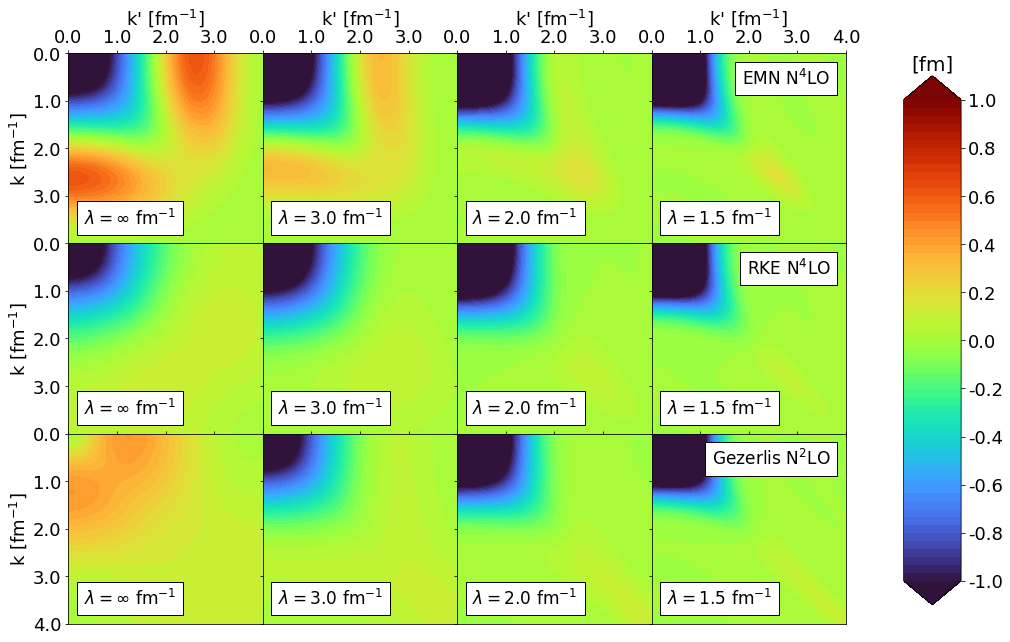

In [25]:
# Plot evolved potentials - contours only

# EM N3LO, RKE N4LO, Gezerlis N2LO for different channels and SRG generators
# 1S0 channel and Wegner generator
#potential_contours('1S0', 'Wegner', lambda_array_contours, em_n3lo, rke_n4lo, gez_n2lo)
# 3S1 channel and Wegner generator
#potential_contours('3S1', 'Wegner', lambda_array_contours, em_n3lo, rke_n4lo, gez_n2lo)
# 1P1 channel and Wegner generator
#potential_contours('1P1', 'Wegner', lambda_array_contours, em_n3lo, rke_n4lo, gez_n2lo)
# 3S1 channel and block-diagonal generator
#potential_contours('3S1', 'Block-diag', lambda_array_contours, em_n3lo, rke_n4lo, gez_n2lo)


# EMN N4LO, RKE N4LO, Gezerlis N2LO for different channels and SRG generators
# 1S0 channel and Wegner generator
#potential_contours('1S0', 'Wegner', lambda_array_contours, emn_n4lo, rke_n4lo, gez_n2lo)
# 3S1 channel and Wegner generator
potential_contours('3S1', 'Wegner', lambda_array_contours, emn_n4lo, rke_n4lo, gez_n2lo)
# 1P1 channel and Wegner generator
#potential_contours('1P1', 'Wegner', lambda_array_contours, emn_n4lo, rke_n4lo, gez_n2lo)
# 1F3 channel and Wegner generator
#potential_contours('1F3', 'Wegner', lambda_array_contours, emn_n4lo, rke_n4lo, gez_n2lo)
# 1G4 channel and Wegner generator
#potential_contours('1G4', 'Wegner', lambda_array_contours, emn_n4lo, rke_n4lo, gez_n2lo)
# 3S1 channel and block-diagonal generator
#potential_contours('3S1', 'Block-diag', lambda_array_contours, emn_n4lo, rke_n4lo, gez_n2lo)
# 1F3 channel and block-diagonal generator
#potential_contours('1F3', 'Block-diag', lambda_array_contours, emn_n4lo, rke_n4lo, gez_n2lo)


# Band- and block-diagonal decoupling for different potentials and channels
# RKE N4LO (450 MeV) and 3S1 channel
#potential_contours_generators(111, '3S1', 8.0, 2.0, ntot, lambda_array_contours)
# RKE N4LO (450 MeV) and 1P1 channel
#potential_contours_generators(111, '1P1', 8.0, 2.0, ntot, lambda_array_contours)
# EMN N4LO (500 MeV) and 1P1 channel
#potential_contours_generators(79, '1P1', 10.0, 2.0, ntot, lambda_array_contours)

In [26]:
# Plot evolved potentials - slices only

# Band- and block-diagonal decoupling for different potentials and channels specifying slices of V(k, k')
# EM N3LO, RKE N4LO, Gezerlis N2LO
# 1S0 channel
# potential_slices('1S0', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# # 3S1 channel
# potential_slices('3S1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# # 1P1 channel
# potential_slices('1P1', lambda_array_slices, em_n3lo, rke_n4lo, gez_n2lo)
# # EMN N4LO, RKE N4LO, Gezerlis N2LO
# # 1S0 channel
# potential_slices('1S0', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)
# # 3S1 channel
# potential_slices('3S1', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)
# # 1P1 channel
# potential_slices('1P1', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)
# # 1F3 channel
# potential_slices('1F3', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)
# # 1G4 channel
# potential_slices('1G4', lambda_array_slices, emn_n4lo, rke_n4lo, gez_n2lo)

# 3S1 channel and high cutoff potentials
# potential_slices_high_cutoffs(lambda_array_high_cutoffs)

# Magnus expansion decoupling for high cutoff potentials in 3S1 channel
# Wegner
#potential_slices_magnus(901, 'Wegner', lambda_array_high_cutoffs, k_magnus_array)
# T_rel
#potential_slices_magnus(901, 'T', lambda_array_high_cutoffs, k_magnus_array)

In [27]:
# Test universality in different potentials

# EMN N4LO and RKE N4LO for various generators
# Wegner
# universality_test_with_norm(channels, 'Wegner', lambda_array_univ, emn_n4lo, rke_n4lo, gez_n2lo)
# # Block-diagonal
# universality_test_with_norm(channels, 'Block-diag', lambda_array_univ, emn_n4lo, rke_n4lo, gez_n2lo)

In [28]:
# Test universality using the correlation coefficient from SDT

# RKE N4LO and EMN N4LO for various generators
# Wegner
# universality_test_with_sdt_coeff(channels, 'Wegner', lambda_array_univ, emn_n4lo, rke_n4lo, gez_n2lo)
# # Block-diag
# universality_test_with_sdt_coeff(channels, 'Block-diag', lambda_array_univ, emn_n4lo, rke_n4lo, gez_n2lo)

In [29]:
# Calculate energies and errors to compare Magnus- and SRG-evolution of Hamiltonians

# Energies from truncated Hamiltonians (test with RKE N4LO)
# PP block, 1S0 channel, block-diagonal
#energies_from_truncated_hamiltonian('PP', 2.0, 111, '1S0', 8.0, 2.0, ntot, 'Block-diag', 1.0, 2.00)
# QQ block, 1S0 channel, block-diagonal
#energies_from_truncated_hamiltonian('QQ', 2.0, 111, '1S0', 8.0, 2.0, ntot, 'Block-diag', 1.0, 2.00)
# PP block, 3S1 channel, block-diagonal
#energies_from_truncated_hamiltonian('PP', 2.0, 111, '3S1', 8.0, 2.0, ntot, 'Block-diag', 1.0, 2.00)
# QQ block, 3S1 channel, block-diagonal
#energies_from_truncated_hamiltonian('QQ', 2.0, 111, '3S1', 8.0, 2.0, ntot, 'Block-diag', 1.0, 2.00)
# getting complex numbers from this???

# Calculate relative on bound state energies for various cases
#bound_states_error(901, 'srg', 'Wegner', 1.2)
#bound_states_error(901, 'magnus', 'Wegner', 1.2, k_magnus=2)

# Calculate RMS error for various cases
#eigenvalues_rms_error(901, 'srg', 'Wegner', 1.2)
#eigenvalues_rms_error(901, 'magnus', 'Wegner', 1.2, k_magnus=2)

In [30]:
# Plot evolved momentum projection operators - contours only

# RKE N4LO for various q values
# q = 0.3 fm^-1
# momentum_projection_contours(0.3, 111, '3S1', 10.0, 2.0, ntot, lambda_array_mpo)
# # q = 3.0 fm^-1
# momentum_projection_contours(3.0, 111, '3S1', 10.0, 2.0, ntot, lambda_array_mpo)

In [31]:
# Plot evolved momentum projection operator matrix elements with deuteron wave function - contours only

# RKE N4LO for various q values
# q = 0.3 fm^-1
# momentum_projection_integrand_contours(0.3, 111, 10.0, 2.0, ntot, lambda_array_mpo)
# # q = 3.0 fm^-1
# momentum_projection_integrand_contours(3.0, 111, 10.0, 2.0, ntot, lambda_array_mpo)

In [32]:
# Plot evolved momentum projection operators - slices only

# EM N3LO, RKE N4LO, Gezerlis N2LO for two q values
# q = 0.3 fm^-1
# momentum_projection_slices(0.3, '3S1', lambda_array_mpo, em_n3lo, rke_n4lo, gez_n2lo)
# # q = 3.0 fm^-1
# momentum_projection_slices(3.0, '3S1', lambda_array_mpo, em_n3lo, rke_n4lo, gez_n2lo)

# EMN N4LO, RKE N4LO, Gezerlis N2LO for two q values
# q = 0.3 fm^-1
# momentum_projection_slices(0.3, '3S1', lambda_array_mpo, emn_n4lo, rke_n4lo, gez_n2lo)
# # q = 3.0 fm^-1
# momentum_projection_slices(3.0, '3S1', lambda_array_mpo, emn_n4lo, rke_n4lo, gez_n2lo)

In [33]:
#r2_diff_logscale(lambda_array_mpo, emn_n4lo, rke_n4lo, gez_n2lo)

In [34]:
# Plot SRG unitary transformations for various potentials, channels, and generators

# Comparing EMN N4LO, RKE N4LO, and Gezerlis N2LO transformations
# Wegner, 3S1
# unitary_transformation_contours('3S1', 'Wegner', lambda_array_unit, emn_n4lo, rke_n4lo, gez_n2lo, logscale=False)
# unitary_transformation_contours('3S1', 'Wegner', lambda_array_unit, emn_n4lo, rke_n4lo, gez_n2lo, logscale=True)
# Block-diagonal, 3S1
# unitary_transformation_contours('3S1', 'Block-diag', lambda_array_unit, emn_n4lo, rke_n4lo, gez_n2lo, logscale=False)
# unitary_transformation_contours('3S1', 'Block-diag', lambda_array_unit, emn_n4lo, rke_n4lo, gez_n2lo, logscale=True)

# unitary_transformation_contours('3S1', 'Wegner', 1.5, emn_n4lo, rke_n4lo, gez_n2lo)
# unitary_transformation_contours('3S1', 'Block-diag', 1.0, emn_n4lo, rke_n4lo, gez_n2lo, lambda_bd=2.00)